# Week 5 - Deep learning with Transformers

Some preliminary set-up.

In [ ]:
! pip install ipywidgets rich seaborn torch datasets transformers tokenizers sentencepiece sacremoses --quiet

%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

sns.set()

# define the device to use
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rich.print(f"Device: [red]{DEVICE}")

# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

Device: cuda

In [ ]:
# prepare data for the later cells
glove_vocabulary, glove_vectors = load_glove_vectors()
rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

# add special tokens
special_tokens = ['<|start|>', '<|unknown|>', '<|pad|>']
glove_vocabulary = special_tokens + glove_vocabulary
glove_vectors = torch.cat([torch.randn_like(glove_vectors[:len(special_tokens)]), glove_vectors])

# tokenizer for GloVe
glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>"))
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

Parsing glove.6B.300d.txt...: 100%|██████████| 400001/400001 [01:18<00:00, 5118.87it/s]


glove_vocabulary: type=<class 'list'>, length=400001

glove_vectors: type=<class 'torch.Tensor'>, shape=torch.Size([400001, 300]), dtype=torch.float32

# Language Modelling and Transformers

___
## Content

* I. Text to vectors
* II. Language models
* III. Attention mechanism
* IV. Transformers
* V. Applications of Transformer-based language models


___
## Introduction

Since its introduction (["Attention is All You Need", Wasrani et al. (2016)](https://arxiv.org/abs/1706.03762)), Transformers have overtaken the field of Machine Learning. Initially applied to translation tasks, Transformers pre-trained on vast amounts of unlabelled data such as BERT and GPT have been acquired as central components in most of the modern natural language processing (NLP) systems. Transformers power question answering (QA) models, machine translation services, search engines and chat bots. Independently of the language applications, the Transformer is also a versatile neural architecture and, therefore, has found success outside the field of NLP. Transformers are rapidly being adopted in image processing (["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Dosovitskiy et al. (2021)](https://arxiv.org/abs/2010.11929)), in reinforcement learning (["A Generalist Agent", Reed et al. (2022)](https://arxiv.org/abs/2205.06175)), video generation (["VideoGPT: Video Generation using VQ-VAE and Transformers", Yan et al. (2021)](https://arxiv.org/abs/2104.10157)), and more. In the following sections, we will first introduce the basics of NLP (tokenization, token embeddings, language modelling), introduce the attention mechanism. In the second part, we will study the Transformer architecture and apply it to NLP tasks.

___
## I. Text to vectors

In the previous labs, we have applied deep learning to processing images encoded as RGB pixels. We found that processing arrays of RGB pixels using convolutional neural network was effective. In NLP, other neural interfaces are required to enable plugging text into neural networks. Raw text cannot trivially be plugged-in neural networks. In this section we show how to convert text units or *tokens* into vectors and introduce the notion of text vector spaces.

### I.a. Tokenization

In [alphabetic languages](https://en.wikipedia.org/wiki/List_of_writing_systems), text can be decomposed into various types of units or *tokens*: characters, syllables, words or even sentences. Each tokenization system comes with vocabulary $\mathcal{V}$ that references all known symbols.

The choice of tokenizer is a tradeoff between the size of the vocabulary and the number of tokens required to encode a sentence. For instance, character-level tokenizers result in a smaller vocabulary size (only 128 character when using ASCII encoding) than other tokenizers. Word-based tokenizers encode text using fewer tokens than the other tokenizers but require a much larger vocabulary, which still might miss words seen at test time. Sub-words tokenizers such as [WordPiece](https://arxiv.org/abs/2012.15524) and [byte-pair encoding (BPE)](https://arxiv.org/abs/1508.07909) are a tradeoff between character-level and word-level encoding. They have progressively taken over the field as they provide two main advantages: (i) good tradeoff between vocabulary size and encoding length, (ii) open-ended vocabulary.

Below we tokenize one sentence using word-level, character-level and sub-word-level tokenizers. In each case, the output corresponds to a sequence of indexes corresponding to the position of the given token in the vocabulary.

In [ ]:
# Example sentence with rare English words and non-english words
sentence = "It is jubilating to see how élégant my horse has became"
rich.print(f"Input sentence: [orange]`{sentence}`")

# Define multiple tokenizers
tokenizer_ids = {
    "Word-level": glove_tokenizer,
    "WordPiece": "bert-base-cased",
    "BPE": "distilgpt2",
    "Character-level":  "google/byt5-small",
    }

# iterate through the tokenizers and decode the input sentences
for tokenizer_name, tokenizer in tokenizer_ids.items():
    # intialize the tokenizer (either)
    if isinstance(tokenizer, str):
        # init a `transformers.PreTrainedTokenizerFast`
        tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer)
        vocab_size = tokenizer.vocab_size
    else:
        # use the provided `tokenizers.Tokenizer``
        vocab_size = tokenizer.get_vocab_size()

    # Tokenize
    token_ids = tokenizer.encode(sentence, add_special_tokens=False)
    if isinstance(token_ids, tokenizers.Encoding):
        token_ids = token_ids.ids

    # Report
    rich.print(f"[red]{tokenizer_name}[/red]: sentence converted into {len(token_ids)} tokens (vocabulary: {vocab_size} tokens)")
    rich.print(f"Tokens:\n{[tokenizer.decode([t]) for t in token_ids]}")
    rich.print(f"Token ids:\n{[t for t in token_ids]}")

### I.b Embeddings

A tokenizer transforms fragments of text into list of integers that maps a vocabulary. We assign one vector of dimension $d$ to each item in the vocabulary of size $N_\mathcal{V}$, this results in a matrix $E$ of dimension ${N_\mathcal{V} \times d}$. Converting a fragment of text into a sequence of vector representations can be done by tokenizing the text, and then looking up the embedding vector for each token, which is equivalent to *one-hot encoding* the tokens and performing a matrix multiplication using $E$. Given $\mathbf{t}_1, \ldots, \mathbf{t}_L$ the sequence of one-hot encoded tokens, this is equivalent to
$$
\mathbf{w}_i = E  \mathbf{t}_i ,
$$
In the code below, we encode the sentence `Hellow world!` using a BPE tokenizer and a set of embedding of dimension `hdim`.

In [ ]:
hdim = 5 # embedding dimension
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased") # tokenizer
sentence = "Hello World!" # input text
embeddings = torch.randn((tokenizer.vocab_size, hdim)) # embedding matrix
rich.print(f"Embeddings (shape): {embeddings.shape}")
token_ids = tokenizer.encode(sentence, add_special_tokens=False, return_tensors="pt")[0]
rich.print(f"Tokens ids (shape): {token_ids.shape}")
vectors =  torch.nn.functional.one_hot(token_ids, tokenizer.vocab_size).float() @ embeddings # equivalent to a `nn.Linear` layer
rich.print(f"Vectors (shape): {vectors.shape}")
rich.print(f"List of tokens and their corresponding vectors:")
for t,v in zip(token_ids, vectors):
    token_info = f"[blue]{tokenizer.decode(t):5}[/blue] (token id: {t:4})"
    rich.print(f" * {token_info} -> {v}")

# NB: in practice, we use the simpler interface `torch.nn.Embedding``
# embeddings = torch.nn.Embedding(tokenizer.vocab_size, hdim)
# vectors = embeddings(token_ids)

### I.c Word vectors

<img src="https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/word2vec-intuition.png?raw=1" alt="Word2vec: translations in the vector spaces correspond to linguistic concepts (gender, verb tense, association between concepts)" width="800px"/>


Word2vec (["Efficient Estimation of Word Representations in Vector Space", Mikolov et al. (2013)](https://arxiv.org/abs/1301.3781)) converts words into vector representations, which are learned using the Skip-Gram algorithm. Intuitively, The algorithm is based on the idea that words that appear together are related to each other.

The word vector space allows to use the inner product to compare words, and arithmetic operations to manipulate word representations. For instance, in a well-defined word vector space, the concept "king" can be translated into "queen" by applying a linear transformation and the vector `vec("captial") - vec("country")` was found to correspond to the relative concept `"capital city of a country"` (see above illustration (*Image credits: https://www.tensorflow.org/tutorials/word2vec*)).


**Experiment** In the first cells, we have downloaded the [GloVe word vectors](ttps://github.com/stanfordnlp/GloVe) from ["GloVe: Global Vectors for Word Representation", Jeffrey Pennington et al. (2014)](https://arxiv.org/abs/1902.11004). GloVe are trained using a Skip-Gram objective on a large collection of documents.

In [ ]:
def word2vec(
        word: str,
        vocabulary:List[str],
        vectors: torch.Tensor
    ) -> Optional[torch.Tensor]:
    """Convert a word into a vector"""
    word = word.lower()
    if word in vocabulary:
        word_idx = vocabulary.index(word)
        return vectors[word_idx]
    else:
        return None

def vec2words(
        vec: torch.Tensor,
        k=5,
        *,
        vocabulary:List[str],
        vectors: torch.Tensor,
        exclude_vecs: List[torch.Tensor] = None,
    ) -> Tuple[List[str], torch.Tensor]:
    """Retrieve the nearest word neighbours for an input vector"""

    # compute the similarity between `vec`and all the vectors in `glove_vectors`
    similarity = vectors @ vec

    # potentially filter out some vocabulary entries
    if exclude_vecs is not None and len(exclude_vecs):
        mask = None
        for e in exclude_vecs:
            mask_ = (vectors == e[None, :]).all(dim=1)
            if mask is None:
                mask = mask_
            else:
                mask |= mask_
        similarity.masked_fill_(mask=mask, value=-math.inf)

    # return the ids of the nearesrt neighbours given the similarity
    nearest_neighbour_ids = torch.argsort(-similarity)[:k]

    # retrieve the corresponding words in the `vocabulary``
    return [vocabulary[idx] for idx in nearest_neighbour_ids], similarity[nearest_neighbour_ids]

# register the vocab and vectors args
glove_args = {'vocabulary':glove_vocabulary, 'vectors':glove_vectors}

# Nearest neighbours
rich.print("[red]Nearest neighbour search:")
for word in ["king", "queen", "dog", "France"]:
    rich.print(f'Nearest neighbours of the word "{word}":')
    word_vec = word2vec(word, **glove_args)
    words, similarities = vec2words(word_vec, k=5, **glove_args, exclude_vecs=[word_vec])
    rich.print(f"Words: {words}")
    rich.print(f"Similarities: {similarities}")

# Word analogies
rich.print("\n[red]Vector arithmetic:")
cases = [
    [("+", "king"), ("-", "man"), ("+", "woman")],
    [("+", "denmark"), ("-", "france"), ("+", "paris")],
    [("+", "pakistan"), ("-", "belgium"), ("+", "brussels")],
]
for operations in cases:
    # current location in the vector space
    location = 0
    rich.print(f"Vector Translation: [blue] {' '.join(f'{d} {v}' for d,v in operations)} = ")
    for sign, word in operations:
        # retrieve the `vec(word)``
        vec = word2vec(word, **glove_args)
        if vec is None:
            raise ValueError(f"Unknown word `{word}`")

        # parse the direction (+/-)
        direction = {"+": 1, "-": -1}[sign]

        # apply the vector transform to the current location
        location  +=  direction * vec

    # return the nearest neighbours of the end location
    exclude_list = [word2vec(w, **glove_args) for _, w in operations]
    words, similarities = vec2words(location, k=5, exclude_vecs=exclude_list, **glove_args)
    rich.print(f"Words: {words}")
    rich.print(f"Similarities: {similarities}")

**Beyond word2vec**  The Skip-Gram model allows us to learn meaningful word representations and arithmetic in the resulting vector space, allowing us to manipulate concepts. Ultimately, we are interested in learning representations that represent larger text fragments such as sentences, paragraphs or documents. Doing so requires combining multiple vectors, which can be done by exploiting arithmetic in the vector space or by combining word-vectors using deep neural networks, such as Transformers!

___
## II. Language models

We have seen how to encode text into sequences of tokens, seen how to convert tokens into vectors using a set of embeddings and experimented with a GloVe word vector space. In this section we will see how to model text at the sentence, pragraph or even document level using language models.

### II.a Language Modelling

*Figure: Left-to-right language models*
![Autoregressive left-to-right language model](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/ar-lm.png?raw=1)

**Autoregressive factorization** Language models aim at grasping the underlying linguistic structure of a text fragment: whereas word vectors model words independently of each others, a language model tracks the grammatical and semantic relationships between word tokens. Given a piece of text encoded into tokens $\mathbf{w}_{1:T} = [\mathbf{w_1}, \ldots, \mathbf{w}_T]$ a *left-to-right* language model describes $\mathbf{w}_{1:T}$ with the following factorization:
$$
 p_\theta(\mathbf{w}_{1:T}) = \prod_{t=1}^T p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t}) \ ,
$$
where $\theta$ is a model parameter. The above *autoregressive* factorization describes a *recursive* function $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$, which is shared across all the time steps. In the above figure, we represent a left-to-right language model with dependencies represented by arrows for fixed steps $t=3$ and $t=4$. Because of this choice of factorization, a language model defines a graphical model where each step $t$ depends on all the previous steps $<t$ and the conditional $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ models the dependendies between the context $\mathbf{w}_{<t}$ and the variable $\mathbf{w}_t$.

**Other factorizations** Autoregressive models are not required to adopt a left-to-right factorization and other forms of factorizations can be implemented (right-to-left or arbitrary permutations). See ["XLNet: Generalized Autoregressive Pretraining for Language Understanding", Yang et al. (2019)](https://arxiv.org/abs/1906.08237) for an example.

*Figure: Categorical distribution over the possible next tokens given the context*
![Categorical distribution](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/categorical-dist.png?raw=1)

**Distribution of the possible next tokens** The distribution $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ is a categorical distribution defined on the whole token vocabulary $\mathcal{v}$. Without loss of generality, we denote $f_\theta(\mathbf{w}_t, \mathbf{w}_{<t})$ the function with parameter $\theta$ that parametrize:
$$
p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t}) = \frac{\exp f_\theta(\mathbf{w}_t, \mathbf{w}_{<t})}{\sum_{\mathbf{v} \in \mathcal{V}} \exp f_\theta(\mathbf{v}, \mathbf{w}_{<t})} \ .
$$
The distribution $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ assigns a probability for each token in the vocabulary to appear right after the context $\mathbf{w}_{<t}$. As pictured in the above figure, many completion are possibles under the model $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$.

**Language models learn contextual representations** Assigning a probability to each word in the vocabulary requires learning abstract representations of the context $\mathbf{w}_{<t}$. For instance, in the horse example, predicting the word "fast" will be easier to predict if some knowledge of the grammatical rules and common sense is acquired. In this example example, the model needs to learn that $\mathbf{w}_4$ must be an adjective, and that this adjective can be attributed to a horse. Therefore, the function $f_\theta$ must acquire a non-trivial representation of the context to make sensible token predictions$.

**Sampling** At each step $t$, the $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ implements a categorical distribution defined on the vocabulary $\mathcal{V}$. Sampling or *generating* text can by iteratively sampling tokens, as showed in the pseudo-code bellow:
```python
ws = [] # placeholder for all the samples w_t
for t in range(T):
    wt_logits = f(ws, theta) # logits of p(w_t | w_{<t})
    wt = Categorical(logits=wt_logits).sample() # sampled w_t
    ws.append(wt) # append the new sample to be used as input in the next step
```
Sampling is often expensive, as it requires one evaluation of the function $f_\theta$ for each step and cannot be trivially parallelized.

**Training** As long as the transition function $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ is differentiable (i.e., using neural networks), a language model can be  trained via maximum likelihood, e.g. maximizing the log-likelihood with the loss:
$$
L = - \log p_\theta(\mathbf{w}_{1:T}) = - \sum_{t=1}^T \log p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})
$$
Each term $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ can be evaluated using the observed variables $\mathbf{w}_t$ and $\mathbf{w}_{<t}$ (no sampling is required) and thus training of auto-regressive models is fast when the evaluation of $f_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ can be parallelized.

*Figure: Bidirectional language models*
![Masked language model](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/masked-lm.png?raw=1)

**Bidirectional and masked language models** Autoregressive language models learn to predict a token $\mathbf{w}_t$ given the context up to the step $t-1$. One can also use a [pseudo likelihood](https://en.wikipedia.org/wiki/Pseudolikelihood), where $\mathbf{w}_t$ is not only conditioned on the preceeding tokens $\mathbf{w}_{<t}$, but also on the next tokens $\mathbf{w}_{>t}$. This defines a bidirectional language model, which factorizes as
$$
L_\theta(\mathbf{w}_{1:T}) = \prod_{t=1}^T p_\theta(\mathbf{w}_t \mid \mathbf{w}_{-t}) \ ,
$$
where $\mathbf{w}_{-t}$ represent the set of tokens $\mathbf{w}_{1:T} \backslash \{ \mathbf{w}_t \}$. We call it pseudo because this likelihood is not forming a valid distribution (because the graph formed by $\mathbf{w}_{1:T}$ is not a directed acyclic graph (a DAG)).  Bidirectional language models such as [ELMo ("Deep contextualized word representations", Peters et al. (2018))](https://arxiv.org/abs/1802.05365), learn token representation contextualized on the whole context.

In the case, of bidirectional language models, the context $\mathbf{w}_{-t}$ corresponds to the whole sequence of tokens with the predicted element masked out. It is possible to generalize the bidirectional factorization to masking out one or more tokens. In that case, we consider a model $p_\theta(\mathbf{w}_m \mid \mathbf{w}_{-m})$ where $m$ is a set of indices of the tokens being predicted and $-m$ is the set of the other tokens. This is notably the approach adopted in ["BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", Delvin et al. (2018)](https://arxiv.org/abs/1810.04805).

### II.b Recurrent Neural Networks

*Figure: Left-to-right recurrent neural network. We highlight the information flowing from the context "My horse is" to the predicted word "very".*
![Recurrent Neural Network](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/recurrent-lm-activated.png?raw=1)

**Recurrent neural networks (RNNs)** implement a recursive function $f_\theta$ using neural networks, which makes them a particularly good fit for sequential data. In the general setting, RNNs model the acquired knowledge at time $t$ using an additional variable $\mathbf{h}_t$ of dimension $d_h$ (*hidden state*). The hidden state at step $t-1$ is updated with the information extracted from the observation $\mathbf{w}_t$ using a function
$$
h_\theta: (\mathbf{w}_{t}, \mathbf{h}_{t-1}) \rightarrow \mathbf{h}_{t} \ ,
$$
which can be imlemented using an arbitrary neural network that takes the tuple $(\mathbf{w}_{t}, \mathbf{h}_t)$ as input and returns a new hidden state $\mathbf{h}_{t+1}$. RRNs can be applied to parametrize language models by projecting the hidden state $\mathbf{t}$ into the vocabulary space using a projection matrix $\mathbf{F} \in \mathcal{R}^{V \times d_h}$. This results in parameterizing the transition distribution as
$$
p_\theta(\cdot \mid \mathbf{w}_{<t}) = \mathrm{Softmax}( \mathbf{h}_t \mathbf{F}^T)
$$
In the above figure, we showcase how a standard RNN can be applied to implement a left-to-right language model, and annotated the diagramm with the function $h_\theta(\mathbf{w}_{t}, \mathbf{h}_{t-1)})$ and the projection matrix $\mathbf{F}$.

**Long Short-Term Memory (LSTM) networks** A standard RNN suffers from [the vanishing gradients problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem) which gives challenges in saving memory over longer sequences. To combat these issues the gated hidden units were created. The two most prominent gated hidden units are the [Long Short-Term Memory (LSTM, Hochreiter and Schmidhuber. (1997))](https://dl.acm.org/doi/10.1162/neco.1997.9.8.1735) cell and the Gated Recurrent Unit (GRU), both of which have shown increased performance in saving and reusing memory in later timesteps. RNNs coupled with gated mechanisms are less prone to the problem of vanishing gradients, and can therefore model dependencies over longer number of steps.

*Figure: bi-directional recurrent neural network. We highlight the information flowing from the context "My horse is" to the predicted word "very" (left-to-right), and the information flowing from the context "fast" (right-to-left).*
![Recurrent Neural Network](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/bidirectional-lm-activated.png?raw=1)

**Bi-directional recurrent neural networks** Using two RNNs running in reverse direction allows building bidirectional language models. The distribution $p_\theta(\mathbf{x}_t \mid \mathbf{x}_{-t})$ can be parameterized as
$$
p_\theta( \cdot \mid \mathbf{x}_{-t}) = \mathrm{Softmax}((\mathbf{h}^\mathrm{forward}_t + \mathbf{h}^\mathrm{reverse}_t) F^T) \ ,
$$
where the hidden state  $\mathbf{h}^\mathrm{bi}_t = \mathbf{h}^\mathrm{forward}_t + \mathbf{h}^\mathrm{reverse}_t$ defines hidden state contextualized on all the tokens but $\mathbf{w}_t$.

This is the strategy adopted by [ELMo ("Deep contextualized word representations", Peters et al. (2018))](https://arxiv.org/abs/1802.05365), which popularized learning deep contextualized representations as a pre-training step, and at the samd time, started a [tradition of naming models after Seame Street characters](https://www.theverge.com/2019/12/11/20993407/ai-language-models-muppets-sesame-street-muppetware-elmo-bert-ernie).

#### Experiment: train your own LSTM language model**

**NB:**  *training on CPU is very slow. If you don't have access to a GPU, it will be difficult to train a model that generate acceptable samples. In the end of the notebook, we will use pre-trained models directly, so feel free to skip this experiment.* **You still need to implement the loss in the training loop.**

In [ ]:
max_dataset_size = 1000 # let's use a small subset for now,
max_seq_size = 10 # and very short sequences

# load and tokenizer the dataset
def batch_tokenize(batch: List[Dict[str, Any]], max_length=max_seq_size, tokenizer: tokenizers.Tokenizer = None, key:str="text") -> torch.Tensor:
    texts = batch[key]
    encodings = tokenizer.encode_batch(texts)
    return {"token_ids": [x.ids[:max_length] for x in encodings]}

# load AG News, take a subset of `max_dataset_size` rows and tokenize
dataset = datasets.load_dataset("ag_news")
dataset = datasets.DatasetDict({split: dset.select(range(max_dataset_size)) if len(dset) > max_dataset_size else dset for split, dset in dataset.items()})
dataset = dataset.map(partial(batch_tokenize, tokenizer=glove_tokenizer), batched=True, num_proc=2, batch_size=10)
rich.print(dataset)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'token_ids'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label', 'token_ids'],
        num_rows: 1000
    })
})

In [ ]:
class RNNLM(torch.nn.Module):
    """A simple implementation of a language model using RNNs."""
    def __init__(self, vectors:torch.Tensor):
        super().__init__()
        # register the embeddings
        self.embeddings = torch.nn.Embedding(*glove_vectors.shape)
        self.embeddings.weight.data = glove_vectors

        # register the LSTM
        self.rnn = torch.nn.LSTM(
            input_size=glove_vectors.shape[1],
            hidden_size=glove_vectors.shape[1],
            num_layers=1,
            batch_first=True,
        )

        # project the output of the LSTM (hidden state) back to the vocabulary space
        self.proj = nn.Linear(glove_vectors.shape[1], glove_vectors.shape[0], bias=False)
        # init the projection using the embeddings weights
        self.proj.weight.data = glove_vectors

    def forward(self, token_ids: torch.Tensor, retain_ws:bool=False) -> torch.Tensor:
        # convert the tokens into vectors
        ws = self.embeddings(token_ids)

        # store the word vectors for debugging
        if retain_ws:
          ws.retain_grad()
          self.ws = ws

        # shift the input `ws` right
        w0 = torch.zeros((ws.shape[0], 1, self.embeddings.weight.shape[1]),
                         device=self.embeddings.weight.device, dtype=torch.long)
        ws_shifted = torch.cat([w0, ws[:, :-1]], dim=1)

        # call the RNN: w_{-1:T-1} -> h{1:T}
        hidden_states, _ = self.rnn(ws_shifted)

        # project the hidden state to the vocabulary space
        logits = self.proj(hidden_states)
        return logits

    def sample(
            self,
            batch_size:int=1,
            num_steps:int=10,
            temperature: float=1.0,
            prevent_repetitions: bool=False
        ):
        token_ids = torch.empty((batch_size, 0), device=self.embeddings.weight.device, dtype=torch.long)
        for t in tqdm(range(num_steps), desc=f"Sampling {num_steps} steps.."):
            logits = self.forward(token_ids)
            logits_t = logits[:, -1:] / temperature
            if prevent_repetitions and t > 0:
                # mask the last generated tokens to avoid repetitions
                logits_t.scatter_(index=token_ids[:,-1:, None], dim=2, value=-math.inf)
            p_wt = torch.distributions.Categorical(logits=logits_t)
            tokens_t = p_wt.sample()
            token_ids = torch.cat([token_ids, tokens_t], dim=1)
        return token_ids


# init RNN initialized from GloVe vectors
# delete the checkpoint if you get `PytorchStreamReader` error
checkpoint_file = Path("rrn-lm.ckpt")
rnn = RNNLM(glove_vectors)
if checkpoint_file.exists():
    # checkpoint_file.unlink() # delete the checkpoint by un-commenting this line
    rnn.load_state_dict(torch.load(checkpoint_file, map_location="cpu"))

**Testing** Let's make sure the autoregressive constrains are enforced ($\mathbf{h}_t$ only depends on $\mathbf{w}_{<t}$). We take differentiate a loss that depends only on a step $t = t'$ for each element $t'$ of the input batch and visualize the gradients with regards to the input word vectors (right after the embedding layers) $\mathbf{w}_{1:T}$. The gradient map tells use which input positions are influencing the differentiated output position.

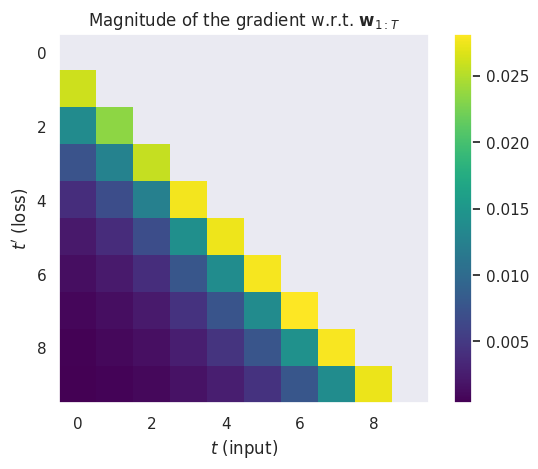

In [ ]:
# Test whether the autoregressive constrains (h_t only depends on w_{<t}) is enforced
rnn.zero_grad()
# get dummy token ids
token_ids = torch.arange(0, 10)
token_ids = token_ids[None].repeat(10, 1)
# run through the RNN
logits = rnn(token_ids, retain_ws=True)

# compute a loss for a which depends only on step `t=i`
loss_locations = torch.arange(0, 10)[:, None, None].expand(10, 1, logits.shape[-1])
loss = logits.gather(index=loss_locations, dim=1).mean()

# backward pass and retrieve the gradients with respect to the word vectors w_{1:T}
loss.backward()
grad_magnitude = rnn.ws.grad.norm(dim=2)
rnn.ws = None

# visualize the gradient
grad_magnitude[grad_magnitude==0] = -math.inf # the the gradient that are exactly zero to -inf for the sake of visualization
grad_magnitude = grad_magnitude.detach().cpu().numpy()
plt.imshow(grad_magnitude, sns.color_palette("viridis", as_cmap=True))
plt.colorbar()
plt.grid(False)
plt.xlabel("$t$ (input)")
plt.ylabel("$t'$ (loss)")
plt.title("Magnitude of the gradient w.r.t. $\mathbf{w}_{1:T}$")
plt.show()

**Exercise 1**: Explain in your own words what the plot shows. How would it look if we had a leakage of information from the future to the present?

> For the output items on the vertical axis, we see the gradient value of each of the input items (on the horizontal axis). The highest ones being i-1, and then after i=t, the values are 0, meaning there is no influence from token further down the sequence.

**Exercise 2**: Implement the loss of the RNN language model.

> answer in the code below.

In [ ]:
# convert token_ids to tensors
def make_batch(batch: List[Dict[str, Any]], max_length=24, key:str="token_ids") -> torch.Tensor:
    """Collate the `token_ids` into a single tensor, pad to minimum length."""
    token_ids = [b[key] for b in batch]
    max_length = min(max_length, *(len(x) for x in token_ids))
    token_ids = [torch.tensor(x) for x in token_ids]
    return torch.stack([x[:max_length] for x in token_ids])

# If you don't have enough GPU memory, decrease the batch size, potentially along with the learning rate.
rnn = rnn.to(DEVICE)

# use Adam optimizer
optimiser = torch.optim.AdamW(rnn.parameters(), lr=1e-3)

# define a data loader to iterate the dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset['train'],
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=list,
)

In [ ]:
# Examinig the output of the forward pass
batch = next(iter(train_loader))
batch_token_ids = make_batch(batch)
batch_token_ids = batch_token_ids.to(DEVICE)

# forward through the model
optimiser.zero_grad()
batch_logits = rnn(batch_token_ids)

# categorical distribution
p_ws = torch.distributions.Categorical(logits=batch_logits)

In [ ]:
print(type(batch))
print(len(batch))

print(type(batch[0]))
print(batch[0].keys())
print(batch[0]['text']) # text enbedded as a token vector
print(batch[0]['label'])
print(batch[0]['token_ids']) # the no of token_ids is the defines size of each sequence

# batch tokens
print('\n--- batch tokens ---')
print(type(batch_token_ids))
print(batch_token_ids.shape) # n_sequences in batch x seq_length
print(batch_token_ids[0])
print(batch_token_ids[-1])

print("\n--- rnn output (logits of the sequences) ---")
print(type(batch_logits))
print(batch_logits.shape) # i.e.(batch_tokens.shape, 'n_tokens_in_vocabulary')

# some token_id in vocabulary, for example one of the token in one sequence
print("\n--- On some random token_id ---")
seq_no = 0
token_idx = 5
token_id = batch_token_ids[seq_no, token_idx]
print(f'batch_token_ids[{seq_no}, {token_idx}] = {token_id}')
print(f"batch_logits[{seq_no}, {token_idx},{token_id}] = token_logit = {batch_logits[0,5,token_id]}")

In [ ]:
# # About the categorical distribution based on logits
# print("--- Categorical distribution through vocabulary---")
# print(type(p_ws))
# # print(p_ws.logits[seq_no, token_idx, token_id])
# print(f'p_ws.probs.shape = {p_ws.probs.shape}') # probs of each token to come up in each pos. in each sequence
# print(p_ws.probs[seq_no, token_idx].sum()) # add up to one

# # On the loss
# # We aim to maximize the log-likleyhood of the sequence
# # We do so by calculating the log-likleyhood of it, which in turn means
# # in every sequence, we add up every log-probability of each token on the sequence
# L = 0
# for seq_idx, sequence_ids in enumerate(batch_token_ids):
#   for token_idx, token_id in enumerate(sequence_ids):
#     # if seq_idx == 10:
#     #   print(f'sequence:{seq_idx}, token_idx:{token_idx} token_prob: {p_ws.probs[seq_idx, token_idx, token_id]}')
#     L += p_ws.probs[seq_idx, token_idx,token_id]

# L *= -1
# print(L)

def batch_log_likleyhood(batch_token_ids:torch.Tensor, batch_probs:torch.Tensor):
  assert (batch_token_ids.shape == batch_probs.shape[0:2]), f'batch and batch probs shapes do not match {batch.shape} {batch_probs.shape}'
  L = 0
  for seq_idx, sequence_ids in enumerate(batch_token_ids):
    for token_idx, token_id in enumerate(sequence_ids):
      # if seq_idx == 10:
      #   print(f'sequence:{seq_idx}, token_idx:{token_idx} token_prob: {p_ws.probs[seq_idx, token_idx, token_id]}')
      L += batch_probs[seq_idx, token_idx,token_id]

  L *= -1
  return L

# L = batch_log_likleyhood(batch_token_ids, p_ws.probs)
# print(L)


In [ ]:
# If you don't have enough GPU memory, decrease the batch size, potentially along with the learning rate.
rnn = rnn.to(DEVICE)
num_steps = 5000 # 5_000
step = 0
epoch = 0
with tqdm(total=num_steps) as pbar:
    while step < num_steps:
        for batch in train_loader:
            # concatenate the `token_ids``
            batch_token_ids = make_batch(batch)
            batch_token_ids = batch_token_ids.to(DEVICE)

            # forward through the model
            optimiser.zero_grad()
            batch_logits = rnn(batch_token_ids)

            # compute the loss (negative log-likelihood)
            p_ws = torch.distributions.Categorical(logits=batch_logits)

            # Exercise: write the loss of the RNN language model
            # hint: check the doc https://pytorch.org/docs/stable/distributions.html#categorical
            # NB: even with the right loss, training is slow and the generated samples won't be very good.
            # ANSWER CODE HERE
            loss = batch_log_likleyhood(batch_token_ids, p_ws.probs)
            print(f"loss: {loss}")

            # backward and optimize
            loss.backward()
            optimiser.step()
            step += 1
            pbar.update(1)

            # Report
            if step % 5 ==0 :
                loss = loss.detach().cpu()
                pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

            # save checkpoint
            if step % 50 ==0 :
                torch.save(rnn.state_dict(), checkpoint_file)
            if step >= num_steps:
                break
        epoch += 1

  0%|          | 0/5000 [00:00<?, ?it/s]

loss: -0.0015116168651729822


  0%|          | 1/5000 [00:09<13:14:08,  9.53s/it]

loss: -0.0014596302062273026


  0%|          | 2/5000 [00:20<14:43:05, 10.60s/it]

loss: -0.001578090712428093


  0%|          | 3/5000 [00:32<15:11:39, 10.95s/it]

loss: -0.0014969659969210625


  0%|          | 4/5000 [00:43<15:24:49, 11.11s/it]

loss: -0.0015384748112410307


epoch=0, step=5, loss=-0.0:   0%|          | 5/5000 [00:57<15:32:04, 11.20s/it]

loss: -0.0014835401671007276


epoch=0, step=5, loss=-0.0:   0%|          | 6/5000 [01:06<15:36:32, 11.25s/it]

loss: -0.0014575780369341373


epoch=0, step=5, loss=-0.0:   0%|          | 7/5000 [01:17<15:39:37, 11.29s/it]

loss: -0.0015352115733548999


epoch=0, step=5, loss=-0.0:   0%|          | 8/5000 [01:29<15:40:33, 11.30s/it]

loss: -0.0014714825665578246


epoch=0, step=5, loss=-0.0:   0%|          | 9/5000 [01:40<15:43:25, 11.34s/it]

loss: -0.0014747317181900144


epoch=0, step=10, loss=-0.0:   0%|          | 10/5000 [01:54<15:45:13, 11.37s/it]

loss: -0.0015159924514591694


epoch=0, step=10, loss=-0.0:   0%|          | 11/5000 [02:03<15:46:50, 11.39s/it]

loss: -0.0015170176047831774


epoch=0, step=10, loss=-0.0:   0%|          | 12/5000 [02:14<15:47:22, 11.40s/it]

loss: -0.0014974871883168817


epoch=0, step=10, loss=-0.0:   0%|          | 13/5000 [02:26<15:48:01, 11.41s/it]

loss: -0.0015160138718783855


epoch=0, step=10, loss=-0.0:   0%|          | 14/5000 [02:37<15:48:07, 11.41s/it]

loss: -0.0015163302887231112


epoch=0, step=15, loss=-0.0:   0%|          | 15/5000 [02:51<15:48:13, 11.41s/it]

loss: -0.0009363838471472263


epoch=0, step=15, loss=-0.0:   0%|          | 16/5000 [02:54<13:18:32,  9.61s/it]

loss: -0.0014687516959384084


epoch=0, step=15, loss=-0.0:   0%|          | 17/5000 [03:05<13:43:11,  9.91s/it]

loss: -0.0015516672283411026


epoch=0, step=15, loss=-0.0:   0%|          | 18/5000 [03:16<14:20:27, 10.36s/it]

loss: -0.0015468858182430267


epoch=0, step=15, loss=-0.0:   0%|          | 19/5000 [03:27<14:46:36, 10.68s/it]

loss: -0.001524825464002788


epoch=1, step=20, loss=-0.0:   0%|          | 20/5000 [03:41<15:04:51, 10.90s/it]

loss: -0.0015715195331722498


epoch=1, step=20, loss=-0.0:   0%|          | 21/5000 [03:50<15:17:41, 11.06s/it]

loss: -0.001490771770477295


epoch=1, step=20, loss=-0.0:   0%|          | 22/5000 [04:02<15:26:14, 11.16s/it]

loss: -0.0015765497228130698


epoch=1, step=20, loss=-0.0:   0%|          | 23/5000 [04:13<15:32:16, 11.24s/it]

loss: -0.0014983878936618567


epoch=1, step=20, loss=-0.0:   0%|          | 24/5000 [04:24<15:36:16, 11.29s/it]

loss: -0.0015590836992487311


epoch=1, step=25, loss=-0.0:   0%|          | 25/5000 [04:38<15:39:10, 11.33s/it]

loss: -0.0014816847397014499


epoch=1, step=25, loss=-0.0:   1%|          | 26/5000 [04:47<15:41:32, 11.36s/it]

loss: -0.0014444846892729402


epoch=1, step=25, loss=-0.0:   1%|          | 27/5000 [04:59<15:42:59, 11.38s/it]

loss: -0.0015130634419620037


epoch=1, step=25, loss=-0.0:   1%|          | 28/5000 [05:10<15:44:03, 11.39s/it]

loss: -0.001494073192588985


epoch=1, step=25, loss=-0.0:   1%|          | 29/5000 [05:22<15:44:21, 11.40s/it]

loss: -0.0014358274638652802


epoch=1, step=30, loss=-0.0:   1%|          | 30/5000 [05:35<15:44:48, 11.41s/it]

loss: -0.0014386606635525823


epoch=1, step=30, loss=-0.0:   1%|          | 31/5000 [05:44<15:45:35, 11.42s/it]

loss: -0.0009103144984692335


epoch=1, step=30, loss=-0.0:   1%|          | 32/5000 [05:50<13:17:00,  9.63s/it]

loss: -0.0014819580828770995


epoch=1, step=30, loss=-0.0:   1%|          | 33/5000 [06:00<13:41:10,  9.92s/it]

loss: -0.0014643622562289238


epoch=1, step=30, loss=-0.0:   1%|          | 34/5000 [06:12<14:18:42, 10.38s/it]

loss: -0.0014377578627318144


epoch=2, step=35, loss=-0.0:   1%|          | 35/5000 [06:26<14:44:25, 10.69s/it]

loss: -0.001457484089769423


epoch=2, step=35, loss=-0.0:   1%|          | 36/5000 [06:35<15:02:30, 10.91s/it]

loss: -0.0015149536775425076


epoch=2, step=35, loss=-0.0:   1%|          | 37/5000 [06:46<15:14:50, 11.06s/it]

loss: -0.0015347196022048593


epoch=2, step=35, loss=-0.0:   1%|          | 38/5000 [06:58<15:23:34, 11.17s/it]

loss: -0.0015277707716450095


epoch=2, step=35, loss=-0.0:   1%|          | 39/5000 [07:09<15:29:46, 11.25s/it]

loss: -0.0015118744922801852


epoch=2, step=40, loss=-0.0:   1%|          | 40/5000 [07:23<15:34:03, 11.30s/it]

loss: -0.001463559572584927


epoch=2, step=40, loss=-0.0:   1%|          | 41/5000 [07:32<15:36:27, 11.33s/it]

loss: -0.0015261673834174871


epoch=2, step=40, loss=-0.0:   1%|          | 42/5000 [07:43<15:38:32, 11.36s/it]

loss: -0.0016150667797774076


epoch=2, step=40, loss=-0.0:   1%|          | 43/5000 [07:55<15:39:50, 11.38s/it]

loss: -0.0015182601055130363


epoch=2, step=40, loss=-0.0:   1%|          | 44/5000 [08:06<15:40:49, 11.39s/it]

loss: -0.0015325270360335708


epoch=2, step=45, loss=-0.0:   1%|          | 45/5000 [08:20<15:41:24, 11.40s/it]

loss: -0.0014897434739395976


epoch=2, step=45, loss=-0.0:   1%|          | 46/5000 [08:29<15:41:38, 11.40s/it]

loss: -0.0015322818653658032


epoch=2, step=45, loss=-0.0:   1%|          | 47/5000 [08:40<15:41:35, 11.41s/it]

loss: -0.0008980663842521608


epoch=2, step=45, loss=-0.0:   1%|          | 48/5000 [08:46<13:13:37,  9.62s/it]

loss: -0.0015135325957089663


epoch=2, step=45, loss=-0.0:   1%|          | 49/5000 [08:56<13:37:46,  9.91s/it]

loss: -0.0014400643995031714


epoch=3, step=50, loss=-0.0:   1%|          | 50/5000 [09:10<14:15:23, 10.37s/it]

loss: -0.0015872388612478971


epoch=3, step=50, loss=-0.0:   1%|          | 51/5000 [09:31<19:28:31, 14.17s/it]

loss: -0.0015315428609028459


epoch=3, step=50, loss=-0.0:   1%|          | 52/5000 [09:42<18:20:28, 13.34s/it]

loss: -0.0015198133187368512


epoch=3, step=50, loss=-0.0:   1%|          | 53/5000 [09:54<17:32:43, 12.77s/it]

loss: -0.0014890145976096392


epoch=3, step=50, loss=-0.0:   1%|          | 54/5000 [10:05<16:59:11, 12.36s/it]

loss: -0.0015595508739352226


epoch=3, step=55, loss=-0.0:   1%|          | 55/5000 [10:19<16:35:39, 12.08s/it]

loss: -0.001378560089506209


epoch=3, step=55, loss=-0.0:   1%|          | 56/5000 [10:28<16:19:23, 11.89s/it]

loss: -0.0016037041787058115


epoch=3, step=55, loss=-0.0:   1%|          | 57/5000 [10:39<16:07:54, 11.75s/it]

loss: -0.0014794011367484927


epoch=3, step=55, loss=-0.0:   1%|          | 58/5000 [10:51<15:59:29, 11.65s/it]

loss: -0.0015184225048869848


epoch=3, step=55, loss=-0.0:   1%|          | 59/5000 [11:02<15:53:54, 11.58s/it]

loss: -0.0015006219036877155


epoch=3, step=60, loss=-0.0:   1%|          | 60/5000 [11:16<15:49:35, 11.53s/it]

loss: -0.0014570978237316012


epoch=3, step=60, loss=-0.0:   1%|          | 61/5000 [11:25<15:47:06, 11.51s/it]

loss: -0.0015487474156543612


epoch=3, step=60, loss=-0.0:   1%|          | 62/5000 [11:37<15:45:01, 11.48s/it]

loss: -0.001421051099896431


epoch=3, step=60, loss=-0.0:   1%|▏         | 63/5000 [11:48<15:43:08, 11.46s/it]

loss: -0.0009581854683347046


epoch=3, step=60, loss=-0.0:   1%|▏         | 64/5000 [11:53<13:14:07,  9.65s/it]

loss: -0.0014883710537105799


epoch=4, step=65, loss=-0.0:   1%|▏         | 65/5000 [12:06<13:37:44,  9.94s/it]

loss: -0.0015226214891299605


epoch=4, step=65, loss=-0.0:   1%|▏         | 66/5000 [12:15<14:14:19, 10.39s/it]

loss: -0.0015482599847018719


epoch=4, step=65, loss=-0.0:   1%|▏         | 67/5000 [12:27<14:39:11, 10.69s/it]

loss: -0.0014574362430721521


epoch=4, step=65, loss=-0.0:   1%|▏         | 68/5000 [12:38<14:56:37, 10.91s/it]

loss: -0.0015352906193584204


epoch=4, step=65, loss=-0.0:   1%|▏         | 69/5000 [12:50<15:09:24, 11.07s/it]

loss: -0.0014908433659002185


epoch=4, step=70, loss=-0.0:   1%|▏         | 70/5000 [13:03<15:17:50, 11.17s/it]

loss: -0.0015197978354990482


epoch=4, step=70, loss=-0.0:   1%|▏         | 71/5000 [13:12<15:23:32, 11.24s/it]

loss: -0.001488974317908287


epoch=4, step=70, loss=-0.0:   1%|▏         | 72/5000 [13:24<15:27:34, 11.29s/it]

loss: -0.001476542791351676


epoch=4, step=70, loss=-0.0:   1%|▏         | 73/5000 [13:35<15:30:23, 11.33s/it]

loss: -0.001471927622333169


epoch=4, step=70, loss=-0.0:   1%|▏         | 74/5000 [13:47<15:32:11, 11.35s/it]

loss: -0.0014927865704521537


epoch=4, step=75, loss=-0.0:   2%|▏         | 75/5000 [14:00<15:33:44, 11.38s/it]

loss: -0.0015010706847533584


epoch=4, step=75, loss=-0.0:   2%|▏         | 76/5000 [14:10<15:34:23, 11.39s/it]

loss: -0.001516635762527585


epoch=4, step=75, loss=-0.0:   2%|▏         | 77/5000 [14:21<15:34:46, 11.39s/it]

loss: -0.0014952303608879447


epoch=4, step=75, loss=-0.0:   2%|▏         | 78/5000 [14:32<15:35:17, 11.40s/it]

loss: -0.0015503820031881332


epoch=4, step=75, loss=-0.0:   2%|▏         | 79/5000 [14:44<15:35:35, 11.41s/it]

loss: -0.0009503808687441051


epoch=4, step=80, loss=-0.0:   2%|▏         | 80/5000 [14:51<13:08:24,  9.61s/it]

loss: -0.0014847932616248727


epoch=4, step=80, loss=-0.0:   2%|▏         | 81/5000 [15:00<13:37:06,  9.97s/it]

loss: -0.0014785164967179298


epoch=4, step=80, loss=-0.0:   2%|▏         | 82/5000 [15:11<14:12:48, 10.40s/it]

loss: -0.0014237312134355307


epoch=4, step=80, loss=-0.0:   2%|▏         | 83/5000 [15:23<14:37:59, 10.71s/it]

loss: -0.0015504913171753287


epoch=4, step=80, loss=-0.0:   2%|▏         | 84/5000 [15:34<14:54:52, 10.92s/it]

loss: -0.001523714978247881


epoch=5, step=85, loss=-0.0:   2%|▏         | 85/5000 [15:48<15:06:49, 11.07s/it]

loss: -0.001472407253459096


epoch=5, step=85, loss=-0.0:   2%|▏         | 86/5000 [15:57<15:15:14, 11.18s/it]

loss: -0.001516899443231523


epoch=5, step=85, loss=-0.0:   2%|▏         | 87/5000 [16:09<15:20:56, 11.25s/it]

loss: -0.0014581064460799098


epoch=5, step=85, loss=-0.0:   2%|▏         | 88/5000 [16:20<15:25:03, 11.30s/it]

loss: -0.0014768908731639385


epoch=5, step=85, loss=-0.0:   2%|▏         | 89/5000 [16:31<15:28:11, 11.34s/it]

loss: -0.0015132848639041185


epoch=5, step=90, loss=-0.0:   2%|▏         | 90/5000 [16:45<15:29:49, 11.36s/it]

loss: -0.0015090516535565257


epoch=5, step=90, loss=-0.0:   2%|▏         | 91/5000 [16:54<15:31:04, 11.38s/it]

loss: -0.0015424606390297413


epoch=5, step=90, loss=-0.0:   2%|▏         | 92/5000 [17:06<15:31:46, 11.39s/it]

loss: -0.0015655047027394176


epoch=5, step=90, loss=-0.0:   2%|▏         | 93/5000 [17:17<15:32:34, 11.40s/it]

loss: -0.0015484212199226022


epoch=5, step=90, loss=-0.0:   2%|▏         | 94/5000 [17:28<15:32:45, 11.41s/it]

loss: -0.0015361887635663152


epoch=5, step=95, loss=-0.0:   2%|▏         | 95/5000 [17:42<15:32:48, 11.41s/it]

loss: -0.0009060882730409503


epoch=5, step=95, loss=-0.0:   2%|▏         | 96/5000 [17:45<13:06:00,  9.62s/it]

loss: -0.0015183488139882684


epoch=5, step=95, loss=-0.0:   2%|▏         | 97/5000 [17:56<13:29:56,  9.91s/it]

loss: -0.0014957115054130554


epoch=5, step=95, loss=-0.0:   2%|▏         | 98/5000 [18:07<14:06:47, 10.36s/it]

loss: -0.001542390207760036


epoch=5, step=95, loss=-0.0:   2%|▏         | 99/5000 [18:19<14:32:27, 10.68s/it]

loss: -0.0014885226264595985


epoch=6, step=100, loss=-0.0:   2%|▏         | 100/5000 [18:32<14:50:36, 10.91s/it]

loss: -0.0015416471287608147


epoch=6, step=100, loss=-0.0:   2%|▏         | 101/5000 [18:49<18:02:45, 13.26s/it]

loss: -0.0014596536057069898


epoch=6, step=100, loss=-0.0:   2%|▏         | 102/5000 [19:00<17:17:13, 12.71s/it]

loss: -0.0015037264674901962


epoch=6, step=100, loss=-0.0:   2%|▏         | 103/5000 [19:12<16:45:19, 12.32s/it]

loss: -0.0015816488303244114


epoch=6, step=100, loss=-0.0:   2%|▏         | 104/5000 [19:23<16:23:13, 12.05s/it]

loss: -0.001532506081275642


epoch=6, step=105, loss=-0.0:   2%|▏         | 105/5000 [19:37<16:07:25, 11.86s/it]

loss: -0.0014778239419683814


epoch=6, step=105, loss=-0.0:   2%|▏         | 106/5000 [19:46<15:56:24, 11.73s/it]

loss: -0.0015058201970532537


epoch=6, step=105, loss=-0.0:   2%|▏         | 107/5000 [19:57<15:48:10, 11.63s/it]

loss: -0.0014926042640581727


epoch=6, step=105, loss=-0.0:   2%|▏         | 108/5000 [20:09<15:42:25, 11.56s/it]

loss: -0.0013785135233774781


epoch=6, step=105, loss=-0.0:   2%|▏         | 109/5000 [20:20<15:39:04, 11.52s/it]

loss: -0.0015166928060352802


epoch=6, step=110, loss=-0.0:   2%|▏         | 110/5000 [20:34<15:36:10, 11.49s/it]

loss: -0.0015060865553095937


epoch=6, step=110, loss=-0.0:   2%|▏         | 111/5000 [20:43<15:34:03, 11.46s/it]

loss: -0.0009648569393903017


epoch=6, step=110, loss=-0.0:   2%|▏         | 112/5000 [20:49<13:06:22,  9.65s/it]

loss: -0.001563472906127572


epoch=6, step=110, loss=-0.0:   2%|▏         | 113/5000 [20:59<13:29:29,  9.94s/it]

loss: -0.0014604328898712993


epoch=6, step=110, loss=-0.0:   2%|▏         | 114/5000 [21:11<14:05:21, 10.38s/it]

loss: -0.001470886985771358


epoch=7, step=115, loss=-0.0:   2%|▏         | 115/5000 [21:24<14:30:23, 10.69s/it]

loss: -0.0015231509460136294


epoch=7, step=115, loss=-0.0:   2%|▏         | 116/5000 [21:33<14:48:03, 10.91s/it]

loss: -0.0015102078905329108


epoch=7, step=115, loss=-0.0:   2%|▏         | 117/5000 [21:45<15:00:49, 11.07s/it]

loss: -0.0014627717901021242


epoch=7, step=115, loss=-0.0:   2%|▏         | 118/5000 [21:56<15:08:43, 11.17s/it]

loss: -0.0015217404579743743


epoch=7, step=115, loss=-0.0:   2%|▏         | 119/5000 [22:08<15:14:44, 11.24s/it]

loss: -0.0015653081936761737


epoch=7, step=120, loss=-0.0:   2%|▏         | 120/5000 [22:21<15:18:31, 11.29s/it]

loss: -0.0014300084440037608


epoch=7, step=120, loss=-0.0:   2%|▏         | 121/5000 [22:30<15:21:32, 11.33s/it]

loss: -0.0015264034736901522


epoch=7, step=120, loss=-0.0:   2%|▏         | 122/5000 [22:42<15:23:46, 11.36s/it]

loss: -0.00148462550714612


epoch=7, step=120, loss=-0.0:   2%|▏         | 123/5000 [22:53<15:24:51, 11.38s/it]

loss: -0.001518117031082511


epoch=7, step=120, loss=-0.0:   2%|▏         | 124/5000 [23:05<15:25:34, 11.39s/it]

loss: -0.0015536188147962093


epoch=7, step=125, loss=-0.0:   2%|▎         | 125/5000 [23:18<15:25:44, 11.39s/it]

loss: -0.0014795102179050446


epoch=7, step=125, loss=-0.0:   3%|▎         | 126/5000 [23:28<15:25:59, 11.40s/it]

loss: -0.001507134991697967


epoch=7, step=125, loss=-0.0:   3%|▎         | 127/5000 [23:39<15:26:33, 11.41s/it]

loss: -0.0009291626629419625


epoch=7, step=125, loss=-0.0:   3%|▎         | 128/5000 [23:44<13:00:42,  9.61s/it]

loss: -0.0014714226126670837


epoch=7, step=125, loss=-0.0:   3%|▎         | 129/5000 [23:55<13:24:59,  9.92s/it]

loss: -0.0015261726221069694


epoch=8, step=130, loss=-0.0:   3%|▎         | 130/5000 [24:09<14:01:52, 10.37s/it]

loss: -0.0015169874532148242


epoch=8, step=130, loss=-0.0:   3%|▎         | 131/5000 [24:18<14:27:22, 10.69s/it]

loss: -0.0014555803500115871


epoch=8, step=130, loss=-0.0:   3%|▎         | 132/5000 [24:29<14:44:56, 10.91s/it]

loss: -0.0015510391676798463


epoch=8, step=130, loss=-0.0:   3%|▎         | 133/5000 [24:41<14:57:12, 11.06s/it]

loss: -0.0014486528234556317


epoch=8, step=130, loss=-0.0:   3%|▎         | 134/5000 [24:52<15:05:24, 11.16s/it]

loss: -0.0014932415215298533


epoch=8, step=135, loss=-0.0:   3%|▎         | 135/5000 [25:06<15:11:44, 11.24s/it]

loss: -0.0015268587740138173


epoch=8, step=135, loss=-0.0:   3%|▎         | 136/5000 [25:15<15:15:59, 11.30s/it]

loss: -0.0015180074842646718


epoch=8, step=135, loss=-0.0:   3%|▎         | 137/5000 [25:26<15:18:42, 11.34s/it]

loss: -0.0015489882789552212


epoch=8, step=135, loss=-0.0:   3%|▎         | 138/5000 [25:38<15:20:25, 11.36s/it]

loss: -0.0015887139597907662


epoch=8, step=135, loss=-0.0:   3%|▎         | 139/5000 [25:49<15:21:22, 11.37s/it]

loss: -0.001481022802181542


epoch=8, step=140, loss=-0.0:   3%|▎         | 140/5000 [26:03<15:22:37, 11.39s/it]

loss: -0.0015007511246949434


epoch=8, step=140, loss=-0.0:   3%|▎         | 141/5000 [26:12<15:23:17, 11.40s/it]

loss: -0.0014895243803039193


epoch=8, step=140, loss=-0.0:   3%|▎         | 142/5000 [26:23<15:23:31, 11.41s/it]

loss: -0.0014628826174885035


epoch=8, step=140, loss=-0.0:   3%|▎         | 143/5000 [26:35<15:23:41, 11.41s/it]

loss: -0.0009267021669074893


epoch=8, step=140, loss=-0.0:   3%|▎         | 144/5000 [26:40<12:58:14,  9.62s/it]

loss: -0.0015180130722001195


epoch=9, step=145, loss=-0.0:   3%|▎         | 145/5000 [26:53<13:21:39,  9.91s/it]

loss: -0.0014838443603366613


epoch=9, step=145, loss=-0.0:   3%|▎         | 146/5000 [27:02<13:58:25, 10.36s/it]

loss: -0.001480913837440312


epoch=9, step=145, loss=-0.0:   3%|▎         | 147/5000 [27:14<14:23:31, 10.68s/it]

loss: -0.0014989105984568596


epoch=9, step=145, loss=-0.0:   3%|▎         | 148/5000 [27:25<14:41:36, 10.90s/it]

loss: -0.0014883250696584582


epoch=9, step=145, loss=-0.0:   3%|▎         | 149/5000 [27:37<14:54:04, 11.06s/it]

loss: -0.0015485031763091683


epoch=9, step=150, loss=-0.0:   3%|▎         | 150/5000 [27:50<15:02:30, 11.17s/it]

loss: -0.0014840428484603763


epoch=9, step=150, loss=-0.0:   3%|▎         | 151/5000 [28:11<19:48:02, 14.70s/it]

loss: -0.0015453980304300785


epoch=9, step=150, loss=-0.0:   3%|▎         | 152/5000 [28:22<18:26:58, 13.70s/it]

loss: -0.001455283840186894


epoch=9, step=150, loss=-0.0:   3%|▎         | 153/5000 [28:34<17:31:45, 13.02s/it]

loss: -0.001543850521557033


epoch=9, step=150, loss=-0.0:   3%|▎         | 154/5000 [28:45<16:52:51, 12.54s/it]

loss: -0.0015151530969887972


epoch=9, step=155, loss=-0.0:   3%|▎         | 155/5000 [28:59<16:25:20, 12.20s/it]

loss: -0.0015242603840306401


epoch=9, step=155, loss=-0.0:   3%|▎         | 156/5000 [29:08<16:06:13, 11.97s/it]

loss: -0.0015368410386145115


epoch=9, step=155, loss=-0.0:   3%|▎         | 157/5000 [29:19<15:52:34, 11.80s/it]

loss: -0.001482998370192945


epoch=9, step=155, loss=-0.0:   3%|▎         | 158/5000 [29:31<15:43:16, 11.69s/it]

loss: -0.001518023549579084


epoch=9, step=155, loss=-0.0:   3%|▎         | 159/5000 [29:42<15:36:35, 11.61s/it]

loss: -0.0008821902447380126


epoch=9, step=160, loss=-0.0:   3%|▎         | 160/5000 [29:49<13:07:01,  9.76s/it]

loss: -0.0014964287402108312


epoch=9, step=160, loss=-0.0:   3%|▎         | 161/5000 [29:59<13:34:14, 10.10s/it]

loss: -0.0014470707392320037


epoch=9, step=160, loss=-0.0:   3%|▎         | 162/5000 [30:10<14:06:14, 10.49s/it]

loss: -0.001521465601399541


epoch=9, step=160, loss=-0.0:   3%|▎         | 163/5000 [30:21<14:28:22, 10.77s/it]

loss: -0.0014836566988378763


epoch=9, step=160, loss=-0.0:   3%|▎         | 164/5000 [30:33<14:43:51, 10.97s/it]

loss: -0.0015488460194319487


epoch=10, step=165, loss=-0.0:   3%|▎         | 165/5000 [30:47<14:54:37, 11.10s/it]

loss: -0.0015587429516017437


epoch=10, step=165, loss=-0.0:   3%|▎         | 166/5000 [30:56<15:02:18, 11.20s/it]

loss: -0.0014901907416060567


epoch=10, step=165, loss=-0.0:   3%|▎         | 167/5000 [31:07<15:07:39, 11.27s/it]

loss: -0.0014763479121029377


epoch=10, step=165, loss=-0.0:   3%|▎         | 168/5000 [31:19<15:10:56, 11.31s/it]

loss: -0.0014326017117127776


epoch=10, step=165, loss=-0.0:   3%|▎         | 169/5000 [31:30<15:12:51, 11.34s/it]

loss: -0.0015358590753749013


epoch=10, step=170, loss=-0.0:   3%|▎         | 170/5000 [31:44<15:14:50, 11.36s/it]

loss: -0.0014803948579356074


epoch=10, step=170, loss=-0.0:   3%|▎         | 171/5000 [31:53<15:16:22, 11.39s/it]

loss: -0.001548552536405623


epoch=10, step=170, loss=-0.0:   3%|▎         | 172/5000 [32:04<15:16:55, 11.40s/it]

loss: -0.0014780915807932615


epoch=10, step=170, loss=-0.0:   3%|▎         | 173/5000 [32:16<15:17:11, 11.40s/it]

loss: -0.0014900576788932085


epoch=10, step=170, loss=-0.0:   3%|▎         | 174/5000 [32:27<15:17:21, 11.41s/it]

loss: -0.0015738820657134056


epoch=10, step=175, loss=-0.0:   4%|▎         | 175/5000 [32:41<15:17:36, 11.41s/it]

loss: -0.0009443637100048363


epoch=10, step=175, loss=-0.0:   4%|▎         | 176/5000 [32:44<12:53:08,  9.62s/it]

loss: -0.0014111336786299944


epoch=10, step=175, loss=-0.0:   4%|▎         | 177/5000 [32:55<13:16:39,  9.91s/it]

loss: -0.0014558322727680206


epoch=10, step=175, loss=-0.0:   4%|▎         | 178/5000 [33:06<13:52:58, 10.36s/it]

loss: -0.0015357176307588816


epoch=10, step=175, loss=-0.0:   4%|▎         | 179/5000 [33:17<14:18:46, 10.69s/it]

loss: -0.0015559126622974873


epoch=11, step=180, loss=-0.0:   4%|▎         | 180/5000 [33:31<14:36:32, 10.91s/it]

loss: -0.001491936156526208


epoch=11, step=180, loss=-0.0:   4%|▎         | 181/5000 [33:40<14:48:35, 11.06s/it]

loss: -0.0014377239858731627


epoch=11, step=180, loss=-0.0:   4%|▎         | 182/5000 [33:52<14:56:54, 11.17s/it]

loss: -0.0015556715661659837


epoch=11, step=180, loss=-0.0:   4%|▎         | 183/5000 [34:03<15:02:44, 11.24s/it]

loss: -0.0014845714904367924


epoch=11, step=180, loss=-0.0:   4%|▎         | 184/5000 [34:14<15:06:30, 11.29s/it]

loss: -0.001568604027852416


epoch=11, step=185, loss=-0.0:   4%|▎         | 185/5000 [34:28<15:09:33, 11.33s/it]

loss: -0.0015420609852299094


epoch=11, step=185, loss=-0.0:   4%|▎         | 186/5000 [34:37<15:11:25, 11.36s/it]

loss: -0.0015176766319200397


epoch=11, step=185, loss=-0.0:   4%|▎         | 187/5000 [34:49<15:12:23, 11.37s/it]

loss: -0.0014737185556441545


epoch=11, step=185, loss=-0.0:   4%|▍         | 188/5000 [35:00<15:13:05, 11.39s/it]

loss: -0.0015511424280703068


epoch=11, step=185, loss=-0.0:   4%|▍         | 189/5000 [35:12<15:13:46, 11.40s/it]

loss: -0.001426373841241002


epoch=11, step=190, loss=-0.0:   4%|▍         | 190/5000 [35:25<15:14:15, 11.40s/it]

loss: -0.0015282584354281425


epoch=11, step=190, loss=-0.0:   4%|▍         | 191/5000 [35:34<15:14:40, 11.41s/it]

loss: -0.0009702141978777945


epoch=11, step=190, loss=-0.0:   4%|▍         | 192/5000 [35:40<12:50:41,  9.62s/it]

loss: -0.0015068522188812494


epoch=11, step=190, loss=-0.0:   4%|▍         | 193/5000 [35:50<13:14:16,  9.91s/it]

loss: -0.0015679781790822744


epoch=11, step=190, loss=-0.0:   4%|▍         | 194/5000 [36:02<13:51:08, 10.38s/it]

loss: -0.0015109303640201688


epoch=12, step=195, loss=-0.0:   4%|▍         | 195/5000 [36:16<14:16:01, 10.69s/it]

loss: -0.001555050490424037


epoch=12, step=195, loss=-0.0:   4%|▍         | 196/5000 [36:25<14:33:13, 10.91s/it]

loss: -0.0014731889823451638


epoch=12, step=195, loss=-0.0:   4%|▍         | 197/5000 [36:36<14:45:25, 11.06s/it]

loss: -0.0014955574879422784


epoch=12, step=195, loss=-0.0:   4%|▍         | 198/5000 [36:48<14:54:13, 11.17s/it]

loss: -0.0014814360765740275


epoch=12, step=195, loss=-0.0:   4%|▍         | 199/5000 [36:59<15:00:21, 11.25s/it]

loss: -0.0015292149037122726


epoch=12, step=200, loss=-0.0:   4%|▍         | 200/5000 [37:13<15:03:47, 11.30s/it]

loss: -0.0014842834789305925


epoch=12, step=200, loss=-0.0:   4%|▍         | 201/5000 [37:33<19:43:00, 14.79s/it]

loss: -0.0014416747726500034


epoch=12, step=200, loss=-0.0:   4%|▍         | 202/5000 [37:45<18:21:40, 13.78s/it]

loss: -0.0015328149311244488


epoch=12, step=200, loss=-0.0:   4%|▍         | 203/5000 [37:56<17:25:09, 13.07s/it]

loss: -0.0014665172202512622


epoch=12, step=200, loss=-0.0:   4%|▍         | 204/5000 [38:08<16:45:08, 12.57s/it]

loss: -0.0015145613579079509


epoch=12, step=205, loss=-0.0:   4%|▍         | 205/5000 [38:21<16:17:06, 12.23s/it]

loss: -0.0015913358656689525


epoch=12, step=205, loss=-0.0:   4%|▍         | 206/5000 [38:30<15:57:28, 11.98s/it]

loss: -0.0014332878636196256


epoch=12, step=205, loss=-0.0:   4%|▍         | 207/5000 [38:42<15:43:40, 11.81s/it]

loss: -0.000921868602745235


epoch=12, step=205, loss=-0.0:   4%|▍         | 208/5000 [38:47<13:10:32,  9.90s/it]

loss: -0.001523272250778973


epoch=12, step=205, loss=-0.0:   4%|▍         | 209/5000 [38:58<13:27:09, 10.11s/it]

loss: -0.0014621802838519216


epoch=13, step=210, loss=-0.0:   4%|▍         | 210/5000 [39:12<13:58:17, 10.50s/it]

loss: -0.0015176611486822367


epoch=13, step=210, loss=-0.0:   4%|▍         | 211/5000 [39:21<14:20:39, 10.78s/it]

loss: -0.0015986132202669978


epoch=13, step=210, loss=-0.0:   4%|▍         | 212/5000 [39:32<14:35:28, 10.97s/it]

loss: -0.0014932574704289436


epoch=13, step=210, loss=-0.0:   4%|▍         | 213/5000 [39:44<14:45:59, 11.10s/it]

loss: -0.0015052688540890813


epoch=13, step=210, loss=-0.0:   4%|▍         | 214/5000 [39:55<14:53:05, 11.20s/it]

loss: -0.0014118514955043793


epoch=13, step=215, loss=-0.0:   4%|▍         | 215/5000 [40:09<14:58:26, 11.27s/it]

loss: -0.0015036702388897538


epoch=13, step=215, loss=-0.0:   4%|▍         | 216/5000 [40:18<15:02:01, 11.31s/it]

loss: -0.0014818741474300623


epoch=13, step=215, loss=-0.0:   4%|▍         | 217/5000 [40:29<15:04:16, 11.34s/it]

loss: -0.001495081465691328


epoch=13, step=215, loss=-0.0:   4%|▍         | 218/5000 [40:41<15:05:47, 11.37s/it]

loss: -0.001550980843603611


epoch=13, step=215, loss=-0.0:   4%|▍         | 219/5000 [40:52<15:06:30, 11.38s/it]

loss: -0.0016031013801693916


epoch=13, step=220, loss=-0.0:   4%|▍         | 220/5000 [41:06<15:07:09, 11.39s/it]

loss: -0.001505258958786726


epoch=13, step=220, loss=-0.0:   4%|▍         | 221/5000 [41:15<15:07:54, 11.40s/it]

loss: -0.0015121478354558349


epoch=13, step=220, loss=-0.0:   4%|▍         | 222/5000 [41:26<15:07:44, 11.40s/it]

loss: -0.0014656606363132596


epoch=13, step=220, loss=-0.0:   4%|▍         | 223/5000 [41:38<15:07:53, 11.40s/it]

loss: -0.0008766730898059905


epoch=13, step=220, loss=-0.0:   4%|▍         | 224/5000 [41:43<12:45:06,  9.61s/it]

loss: -0.0015014505479484797


epoch=14, step=225, loss=-0.0:   4%|▍         | 225/5000 [41:56<13:08:31,  9.91s/it]

loss: -0.0015088965883478522


epoch=14, step=225, loss=-0.0:   5%|▍         | 226/5000 [42:05<13:44:15, 10.36s/it]

loss: -0.0015034155221655965


epoch=14, step=225, loss=-0.0:   5%|▍         | 227/5000 [42:17<14:09:08, 10.67s/it]

loss: -0.0015457415720447898


epoch=14, step=225, loss=-0.0:   5%|▍         | 228/5000 [42:28<14:26:41, 10.90s/it]

loss: -0.0015240805223584175


epoch=14, step=225, loss=-0.0:   5%|▍         | 229/5000 [42:39<14:39:23, 11.06s/it]

loss: -0.0014879516093060374


epoch=14, step=230, loss=-0.0:   5%|▍         | 230/5000 [42:53<14:47:19, 11.16s/it]

loss: -0.001426972565241158


epoch=14, step=230, loss=-0.0:   5%|▍         | 231/5000 [43:02<14:53:32, 11.24s/it]

loss: -0.0014476680662482977


epoch=14, step=230, loss=-0.0:   5%|▍         | 232/5000 [43:14<14:57:20, 11.29s/it]

loss: -0.0015165491495281458


epoch=14, step=230, loss=-0.0:   5%|▍         | 233/5000 [43:25<14:59:55, 11.33s/it]

loss: -0.001571820699609816


epoch=14, step=230, loss=-0.0:   5%|▍         | 234/5000 [43:37<15:02:04, 11.36s/it]

loss: -0.001505873748101294


epoch=14, step=235, loss=-0.0:   5%|▍         | 235/5000 [43:50<15:03:41, 11.38s/it]

loss: -0.001499977894127369


epoch=14, step=235, loss=-0.0:   5%|▍         | 236/5000 [43:59<15:04:03, 11.39s/it]

loss: -0.0015558484010398388


epoch=14, step=235, loss=-0.0:   5%|▍         | 237/5000 [44:11<15:04:27, 11.39s/it]

loss: -0.001426016096957028


epoch=14, step=235, loss=-0.0:   5%|▍         | 238/5000 [44:22<15:04:41, 11.40s/it]

loss: -0.0015586565714329481


epoch=14, step=235, loss=-0.0:   5%|▍         | 239/5000 [44:34<15:04:58, 11.40s/it]

loss: -0.0009256300400011241


epoch=14, step=240, loss=-0.0:   5%|▍         | 240/5000 [44:40<12:42:32,  9.61s/it]

loss: -0.0014949861215427518


epoch=14, step=240, loss=-0.0:   5%|▍         | 241/5000 [44:50<13:10:03,  9.96s/it]

loss: -0.0014619043795391917


epoch=14, step=240, loss=-0.0:   5%|▍         | 242/5000 [45:01<13:45:07, 10.41s/it]

loss: -0.0014609391801059246


epoch=14, step=240, loss=-0.0:   5%|▍         | 243/5000 [45:13<14:09:19, 10.71s/it]

loss: -0.001544886501505971


epoch=14, step=240, loss=-0.0:   5%|▍         | 244/5000 [45:24<14:26:00, 10.93s/it]

loss: -0.0014682572800666094


epoch=15, step=245, loss=-0.0:   5%|▍         | 245/5000 [45:38<14:37:39, 11.07s/it]

loss: -0.0015755753265693784


epoch=15, step=245, loss=-0.0:   5%|▍         | 246/5000 [45:47<14:45:48, 11.18s/it]

loss: -0.0014884189004078507


epoch=15, step=245, loss=-0.0:   5%|▍         | 247/5000 [45:58<14:51:30, 11.25s/it]

loss: -0.0014806718099862337


epoch=15, step=245, loss=-0.0:   5%|▍         | 248/5000 [46:10<14:55:32, 11.31s/it]

loss: -0.001470640185289085


epoch=15, step=245, loss=-0.0:   5%|▍         | 249/5000 [46:21<14:57:49, 11.34s/it]

loss: -0.001492176903411746


epoch=15, step=250, loss=-0.0:   5%|▌         | 250/5000 [46:35<14:59:41, 11.36s/it]

loss: -0.0015054631512612104


epoch=15, step=250, loss=-0.0:   5%|▌         | 251/5000 [47:02<22:13:39, 16.85s/it]

loss: -0.0015127550577744842


epoch=15, step=250, loss=-0.0:   5%|▌         | 252/5000 [47:14<20:04:08, 15.22s/it]

loss: -0.0014156632823869586


epoch=15, step=250, loss=-0.0:   5%|▌         | 253/5000 [47:25<18:33:42, 14.08s/it]

loss: -0.0015849947230890393


epoch=15, step=250, loss=-0.0:   5%|▌         | 254/5000 [47:37<17:30:35, 13.28s/it]

loss: -0.0016444927314296365


epoch=15, step=255, loss=-0.0:   5%|▌         | 255/5000 [47:50<16:46:31, 12.73s/it]

loss: -0.0009047272615134716


epoch=15, step=255, loss=-0.0:   5%|▌         | 256/5000 [47:53<13:53:20, 10.54s/it]

loss: -0.0015617923345416784


epoch=15, step=255, loss=-0.0:   5%|▌         | 257/5000 [48:04<13:54:34, 10.56s/it]

loss: -0.0015334229683503509


epoch=15, step=255, loss=-0.0:   5%|▌         | 258/5000 [48:15<14:14:47, 10.82s/it]

loss: -0.0015559011371806264


epoch=15, step=255, loss=-0.0:   5%|▌         | 259/5000 [48:27<14:28:58, 11.00s/it]

loss: -0.0015299117658287287


epoch=16, step=260, loss=-0.0:   5%|▌         | 260/5000 [48:41<14:38:39, 11.12s/it]

loss: -0.0014677729923278093


epoch=16, step=260, loss=-0.0:   5%|▌         | 261/5000 [48:50<14:45:23, 11.21s/it]

loss: -0.001547597348690033


epoch=16, step=260, loss=-0.0:   5%|▌         | 262/5000 [49:01<14:50:03, 11.27s/it]

loss: -0.0015396177768707275


epoch=16, step=260, loss=-0.0:   5%|▌         | 263/5000 [49:13<14:53:30, 11.32s/it]

loss: -0.0015000248095020652


epoch=16, step=260, loss=-0.0:   5%|▌         | 264/5000 [49:24<14:56:02, 11.35s/it]

loss: -0.0015095773851498961


epoch=16, step=265, loss=-0.0:   5%|▌         | 265/5000 [49:38<14:57:41, 11.38s/it]

loss: -0.0014908014563843608


epoch=16, step=265, loss=-0.0:   5%|▌         | 266/5000 [49:47<14:58:14, 11.38s/it]

loss: -0.0014654860133305192


epoch=16, step=265, loss=-0.0:   5%|▌         | 267/5000 [49:58<14:58:37, 11.39s/it]

loss: -0.0014490288449451327


epoch=16, step=265, loss=-0.0:   5%|▌         | 268/5000 [50:10<14:59:17, 11.40s/it]

loss: -0.001434558187611401


epoch=16, step=265, loss=-0.0:   5%|▌         | 269/5000 [50:21<14:59:30, 11.41s/it]

loss: -0.00145609094761312


epoch=16, step=270, loss=-0.0:   5%|▌         | 270/5000 [50:35<14:59:12, 11.41s/it]

loss: -0.0014962063869461417


epoch=16, step=270, loss=-0.0:   5%|▌         | 271/5000 [50:44<14:59:17, 11.41s/it]

loss: -0.0009687624406069517


epoch=16, step=270, loss=-0.0:   5%|▌         | 272/5000 [50:49<12:37:46,  9.62s/it]

loss: -0.0015048622153699398


epoch=16, step=270, loss=-0.0:   5%|▌         | 273/5000 [51:00<13:00:56,  9.91s/it]

loss: -0.001569553860463202


epoch=16, step=270, loss=-0.0:   5%|▌         | 274/5000 [51:11<13:36:13, 10.36s/it]

loss: -0.0014927913434803486


epoch=17, step=275, loss=-0.0:   6%|▌         | 275/5000 [51:25<14:01:05, 10.68s/it]

loss: -0.0015502419555559754


epoch=17, step=275, loss=-0.0:   6%|▌         | 276/5000 [51:34<14:18:39, 10.91s/it]

loss: -0.0014831034932285547


epoch=17, step=275, loss=-0.0:   6%|▌         | 277/5000 [51:46<14:30:52, 11.06s/it]

loss: -0.0014781171921640635


epoch=17, step=275, loss=-0.0:   6%|▌         | 278/5000 [51:57<14:39:04, 11.17s/it]

loss: -0.001455860328860581


epoch=17, step=275, loss=-0.0:   6%|▌         | 279/5000 [52:08<14:44:42, 11.24s/it]

loss: -0.0014819608768448234


epoch=17, step=280, loss=-0.0:   6%|▌         | 280/5000 [52:22<14:48:41, 11.30s/it]

loss: -0.0014973960351198912


epoch=17, step=280, loss=-0.0:   6%|▌         | 281/5000 [52:31<14:52:08, 11.34s/it]

loss: -0.001474681543186307


epoch=17, step=280, loss=-0.0:   6%|▌         | 282/5000 [52:43<14:54:06, 11.37s/it]

loss: -0.0014997522812336683


epoch=17, step=280, loss=-0.0:   6%|▌         | 283/5000 [52:54<14:54:41, 11.38s/it]

loss: -0.0015115126734599471


epoch=17, step=280, loss=-0.0:   6%|▌         | 284/5000 [53:06<14:55:10, 11.39s/it]

loss: -0.001491681206971407


epoch=17, step=285, loss=-0.0:   6%|▌         | 285/5000 [53:19<14:55:22, 11.39s/it]

loss: -0.0014819877687841654


epoch=17, step=285, loss=-0.0:   6%|▌         | 286/5000 [53:28<14:55:32, 11.40s/it]

loss: -0.0015152962878346443


epoch=17, step=285, loss=-0.0:   6%|▌         | 287/5000 [53:40<14:55:40, 11.40s/it]

loss: -0.0010177497752010822


epoch=17, step=285, loss=-0.0:   6%|▌         | 288/5000 [53:45<12:34:50,  9.61s/it]

loss: -0.0015597448218613863


epoch=17, step=285, loss=-0.0:   6%|▌         | 289/5000 [53:56<12:58:19,  9.91s/it]

loss: -0.001561412587761879


epoch=18, step=290, loss=-0.0:   6%|▌         | 290/5000 [54:09<13:33:35, 10.36s/it]

loss: -0.001490232301875949


epoch=18, step=290, loss=-0.0:   6%|▌         | 291/5000 [54:19<13:58:17, 10.68s/it]

loss: -0.001441279542632401


epoch=18, step=290, loss=-0.0:   6%|▌         | 292/5000 [54:30<14:15:16, 10.90s/it]

loss: -0.0014769971603527665


epoch=18, step=290, loss=-0.0:   6%|▌         | 293/5000 [54:41<14:27:07, 11.05s/it]

loss: -0.0015140732284635305


epoch=18, step=290, loss=-0.0:   6%|▌         | 294/5000 [54:53<14:35:31, 11.16s/it]

loss: -0.0014007620047777891


epoch=18, step=295, loss=-0.0:   6%|▌         | 295/5000 [55:07<14:41:39, 11.24s/it]

loss: -0.0015058128628879786


epoch=18, step=295, loss=-0.0:   6%|▌         | 296/5000 [55:16<14:45:36, 11.30s/it]

loss: -0.0015232808655127883


epoch=18, step=295, loss=-0.0:   6%|▌         | 297/5000 [55:27<14:48:14, 11.33s/it]

loss: -0.00153573218267411


epoch=18, step=295, loss=-0.0:   6%|▌         | 298/5000 [55:39<14:50:00, 11.36s/it]

loss: -0.001524076797068119


epoch=18, step=295, loss=-0.0:   6%|▌         | 299/5000 [55:50<14:51:03, 11.37s/it]

loss: -0.0014958702959120274


epoch=18, step=300, loss=-0.0:   6%|▌         | 300/5000 [56:04<14:51:58, 11.39s/it]

loss: -0.0014987785834819078


epoch=18, step=300, loss=-0.0:   6%|▌         | 301/5000 [56:33<22:34:28, 17.29s/it]

loss: -0.001540672266855836


epoch=18, step=300, loss=-0.0:   6%|▌         | 302/5000 [56:44<20:15:53, 15.53s/it]

loss: -0.0015136311994865537


epoch=18, step=300, loss=-0.0:   6%|▌         | 303/5000 [56:55<18:39:28, 14.30s/it]

loss: -0.0009241920197382569


epoch=18, step=300, loss=-0.0:   6%|▌         | 304/5000 [57:01<15:11:05, 11.64s/it]

loss: -0.0014885150594636798


epoch=19, step=305, loss=-0.0:   6%|▌         | 305/5000 [57:14<14:46:24, 11.33s/it]

loss: -0.0015039861900731921


epoch=19, step=305, loss=-0.0:   6%|▌         | 306/5000 [57:23<14:48:40, 11.36s/it]

loss: -0.0014907297445461154


epoch=19, step=305, loss=-0.0:   6%|▌         | 307/5000 [57:34<14:49:54, 11.38s/it]

loss: -0.0015662265941500664


epoch=19, step=305, loss=-0.0:   6%|▌         | 308/5000 [57:46<14:50:25, 11.39s/it]

loss: -0.0014532364439219236


epoch=19, step=305, loss=-0.0:   6%|▌         | 309/5000 [57:57<14:50:42, 11.39s/it]

loss: -0.0015524817863479257


epoch=19, step=310, loss=-0.0:   6%|▌         | 310/5000 [58:11<14:51:15, 11.40s/it]

loss: -0.0015505726914852858


epoch=19, step=310, loss=-0.0:   6%|▌         | 311/5000 [58:20<14:51:55, 11.41s/it]

loss: -0.0015383175341412425


epoch=19, step=310, loss=-0.0:   6%|▌         | 312/5000 [58:31<14:51:56, 11.42s/it]

loss: -0.0014789964770898223


epoch=19, step=310, loss=-0.0:   6%|▋         | 313/5000 [58:43<14:51:58, 11.42s/it]

loss: -0.0014667287468910217


epoch=19, step=310, loss=-0.0:   6%|▋         | 314/5000 [58:54<14:51:50, 11.42s/it]

loss: -0.0014719321625307202


epoch=19, step=315, loss=-0.0:   6%|▋         | 315/5000 [59:08<14:51:41, 11.42s/it]

loss: -0.0014601332368329167


epoch=19, step=315, loss=-0.0:   6%|▋         | 316/5000 [59:17<14:51:46, 11.42s/it]

loss: -0.0015112634282559156


epoch=19, step=315, loss=-0.0:   6%|▋         | 317/5000 [59:28<14:51:41, 11.42s/it]

loss: -0.0015803808346390724


epoch=19, step=315, loss=-0.0:   6%|▋         | 318/5000 [59:40<14:51:10, 11.42s/it]

loss: -0.0014851384330540895


epoch=19, step=315, loss=-0.0:   6%|▋         | 319/5000 [59:51<14:50:35, 11.42s/it]

loss: -0.0009079123265109956


epoch=19, step=320, loss=-0.0:   6%|▋         | 320/5000 [59:58<12:30:20,  9.62s/it]

loss: -0.0014507643645629287


epoch=19, step=320, loss=-0.0:   6%|▋         | 321/5000 [1:00:07<12:57:38,  9.97s/it]

loss: -0.0015228744596242905


epoch=19, step=320, loss=-0.0:   6%|▋         | 322/5000 [1:00:19<13:31:23, 10.41s/it]

loss: -0.0014314103173092008


epoch=19, step=320, loss=-0.0:   6%|▋         | 323/5000 [1:00:30<13:54:48, 10.71s/it]

loss: -0.001455638324841857


epoch=19, step=320, loss=-0.0:   6%|▋         | 324/5000 [1:00:42<14:11:21, 10.92s/it]

loss: -0.0015324866399168968


epoch=20, step=325, loss=-0.0:   6%|▋         | 325/5000 [1:00:55<14:22:50, 11.07s/it]

loss: -0.001554769347421825


epoch=20, step=325, loss=-0.0:   7%|▋         | 326/5000 [1:01:05<14:30:25, 11.17s/it]

loss: -0.0015552567783743143


epoch=20, step=325, loss=-0.0:   7%|▋         | 327/5000 [1:01:16<14:35:50, 11.25s/it]

loss: -0.0014898976078256965


epoch=20, step=325, loss=-0.0:   7%|▋         | 328/5000 [1:01:27<14:39:47, 11.30s/it]

loss: -0.0015732503961771727


epoch=20, step=325, loss=-0.0:   7%|▋         | 329/5000 [1:01:39<14:42:38, 11.34s/it]

loss: -0.0014896602369844913


epoch=20, step=330, loss=-0.0:   7%|▋         | 330/5000 [1:01:53<14:44:35, 11.37s/it]

loss: -0.0015016297111287713


epoch=20, step=330, loss=-0.0:   7%|▋         | 331/5000 [1:02:02<14:45:31, 11.38s/it]

loss: -0.001492016133852303


epoch=20, step=330, loss=-0.0:   7%|▋         | 332/5000 [1:02:13<14:45:56, 11.39s/it]

loss: -0.0014947333838790655


epoch=20, step=330, loss=-0.0:   7%|▋         | 333/5000 [1:02:25<14:46:24, 11.40s/it]

loss: -0.0015041473088786006


epoch=20, step=330, loss=-0.0:   7%|▋         | 334/5000 [1:02:36<14:46:29, 11.40s/it]

loss: -0.001530220964923501


epoch=20, step=335, loss=-0.0:   7%|▋         | 335/5000 [1:02:50<14:46:50, 11.41s/it]

loss: -0.000927789369598031


epoch=20, step=335, loss=-0.0:   7%|▋         | 336/5000 [1:02:53<12:27:11,  9.61s/it]

loss: -0.001509309746325016


epoch=20, step=335, loss=-0.0:   7%|▋         | 337/5000 [1:03:03<12:50:18,  9.91s/it]

loss: -0.0014715745346620679


epoch=20, step=335, loss=-0.0:   7%|▋         | 338/5000 [1:03:15<13:25:13, 10.36s/it]

loss: -0.001458206563256681


epoch=20, step=335, loss=-0.0:   7%|▋         | 339/5000 [1:03:26<13:49:33, 10.68s/it]

loss: -0.001571312895976007


epoch=21, step=340, loss=-0.0:   7%|▋         | 340/5000 [1:03:40<14:06:28, 10.90s/it]

loss: -0.0014906912110745907


epoch=21, step=340, loss=-0.0:   7%|▋         | 341/5000 [1:03:49<14:18:13, 11.05s/it]

loss: -0.0015068589709699154


epoch=21, step=340, loss=-0.0:   7%|▋         | 342/5000 [1:04:00<14:26:28, 11.16s/it]

loss: -0.001480189384892583


epoch=21, step=340, loss=-0.0:   7%|▋         | 343/5000 [1:04:12<14:32:17, 11.24s/it]

loss: -0.0015276905614882708


epoch=21, step=340, loss=-0.0:   7%|▋         | 344/5000 [1:04:23<14:36:25, 11.29s/it]

loss: -0.0015666319523006678


epoch=21, step=345, loss=-0.0:   7%|▋         | 345/5000 [1:04:37<14:39:03, 11.33s/it]

loss: -0.0015232204459607601


epoch=21, step=345, loss=-0.0:   7%|▋         | 346/5000 [1:04:46<14:40:54, 11.36s/it]

loss: -0.001505168853327632


epoch=21, step=345, loss=-0.0:   7%|▋         | 347/5000 [1:04:58<14:42:03, 11.37s/it]

loss: -0.0014985091984272003


epoch=21, step=345, loss=-0.0:   7%|▋         | 348/5000 [1:05:09<14:43:06, 11.39s/it]

loss: -0.0015303314430639148


epoch=21, step=345, loss=-0.0:   7%|▋         | 349/5000 [1:05:20<14:43:32, 11.40s/it]

loss: -0.0014640212757512927


epoch=21, step=350, loss=-0.0:   7%|▋         | 350/5000 [1:05:34<14:43:45, 11.40s/it]

loss: -0.00152350845746696


epoch=21, step=350, loss=-0.0:   7%|▋         | 351/5000 [1:06:00<21:18:50, 16.50s/it]

loss: -0.0008793286397121847


epoch=21, step=350, loss=-0.0:   7%|▋         | 352/5000 [1:06:06<17:01:19, 13.18s/it]

loss: -0.0015196023741737008


epoch=21, step=350, loss=-0.0:   7%|▋         | 353/5000 [1:06:16<16:01:41, 12.42s/it]

loss: -0.0015047405613586307


epoch=21, step=350, loss=-0.0:   7%|▋         | 354/5000 [1:06:28<15:38:16, 12.12s/it]

loss: -0.0015316058415919542


epoch=22, step=355, loss=-0.0:   7%|▋         | 355/5000 [1:06:41<15:22:07, 11.91s/it]

loss: -0.0014929571188986301


epoch=22, step=355, loss=-0.0:   7%|▋         | 356/5000 [1:06:51<15:10:27, 11.76s/it]

loss: -0.0014348970726132393


epoch=22, step=355, loss=-0.0:   7%|▋         | 357/5000 [1:07:02<15:02:27, 11.66s/it]

loss: -0.0014190092915669084


epoch=22, step=355, loss=-0.0:   7%|▋         | 358/5000 [1:07:13<14:56:33, 11.59s/it]

loss: -0.001502716331742704


epoch=22, step=355, loss=-0.0:   7%|▋         | 359/5000 [1:07:25<14:52:05, 11.53s/it]

loss: -0.0014926327858120203


epoch=22, step=360, loss=-0.0:   7%|▋         | 360/5000 [1:07:38<14:49:06, 11.50s/it]

loss: -0.0014651869423687458


epoch=22, step=360, loss=-0.0:   7%|▋         | 361/5000 [1:07:48<14:47:06, 11.47s/it]

loss: -0.0015376557130366564


epoch=22, step=360, loss=-0.0:   7%|▋         | 362/5000 [1:07:59<14:45:38, 11.46s/it]

loss: -0.001546897692605853


epoch=22, step=360, loss=-0.0:   7%|▋         | 363/5000 [1:08:10<14:44:59, 11.45s/it]

loss: -0.0014652949757874012


epoch=22, step=360, loss=-0.0:   7%|▋         | 364/5000 [1:08:22<14:43:53, 11.44s/it]

loss: -0.00149590615183115


epoch=22, step=365, loss=-0.0:   7%|▋         | 365/5000 [1:08:36<14:43:09, 11.43s/it]

loss: -0.0015671455767005682


epoch=22, step=365, loss=-0.0:   7%|▋         | 366/5000 [1:08:45<14:42:27, 11.43s/it]

loss: -0.0016024118522182107


epoch=22, step=365, loss=-0.0:   7%|▋         | 367/5000 [1:08:56<14:42:05, 11.42s/it]

loss: -0.000927895656786859


epoch=22, step=365, loss=-0.0:   7%|▋         | 368/5000 [1:09:02<12:23:41,  9.63s/it]

loss: -0.00158802536316216


epoch=22, step=365, loss=-0.0:   7%|▋         | 369/5000 [1:09:12<12:45:50,  9.92s/it]

loss: -0.0014495080104097724


epoch=23, step=370, loss=-0.0:   7%|▋         | 370/5000 [1:09:26<13:20:17, 10.37s/it]

loss: -0.0014206783380359411


epoch=23, step=370, loss=-0.0:   7%|▋         | 371/5000 [1:09:35<13:44:24, 10.69s/it]

loss: -0.001544525963254273


epoch=23, step=370, loss=-0.0:   7%|▋         | 372/5000 [1:09:46<14:01:04, 10.90s/it]

loss: -0.0015308496076613665


epoch=23, step=370, loss=-0.0:   7%|▋         | 373/5000 [1:09:58<14:12:44, 11.06s/it]

loss: -0.0014914564089849591


epoch=23, step=370, loss=-0.0:   7%|▋         | 374/5000 [1:10:09<14:20:43, 11.16s/it]

loss: -0.001472613774240017


epoch=23, step=375, loss=-0.0:   8%|▊         | 375/5000 [1:10:23<14:26:16, 11.24s/it]

loss: -0.0015033845556899905


epoch=23, step=375, loss=-0.0:   8%|▊         | 376/5000 [1:10:32<14:30:39, 11.30s/it]

loss: -0.0015166262164711952


epoch=23, step=375, loss=-0.0:   8%|▊         | 377/5000 [1:10:44<14:33:16, 11.33s/it]

loss: -0.0015147936064749956


epoch=23, step=375, loss=-0.0:   8%|▊         | 378/5000 [1:10:55<14:35:00, 11.36s/it]

loss: -0.0015289539005607367


epoch=23, step=375, loss=-0.0:   8%|▊         | 379/5000 [1:11:06<14:36:23, 11.38s/it]

loss: -0.001548015046864748


epoch=23, step=380, loss=-0.0:   8%|▊         | 380/5000 [1:11:20<14:37:00, 11.39s/it]

loss: -0.0015526307979598641


epoch=23, step=380, loss=-0.0:   8%|▊         | 381/5000 [1:11:29<14:37:49, 11.40s/it]

loss: -0.0014511673944070935


epoch=23, step=380, loss=-0.0:   8%|▊         | 382/5000 [1:11:41<14:38:02, 11.41s/it]

loss: -0.0015047637280076742


epoch=23, step=380, loss=-0.0:   8%|▊         | 383/5000 [1:11:52<14:37:57, 11.41s/it]

loss: -0.0008885570568963885


epoch=23, step=380, loss=-0.0:   8%|▊         | 384/5000 [1:11:57<12:19:57,  9.62s/it]

loss: -0.0015767400618642569


epoch=24, step=385, loss=-0.0:   8%|▊         | 385/5000 [1:12:10<12:42:27,  9.91s/it]

loss: -0.001517319935373962


epoch=24, step=385, loss=-0.0:   8%|▊         | 386/5000 [1:12:20<13:16:57, 10.36s/it]

loss: -0.0014600303256884217


epoch=24, step=385, loss=-0.0:   8%|▊         | 387/5000 [1:12:31<13:41:06, 10.68s/it]

loss: -0.0014948066091164947


epoch=24, step=385, loss=-0.0:   8%|▊         | 388/5000 [1:12:42<13:57:58, 10.90s/it]

loss: -0.0014580858405679464


epoch=24, step=385, loss=-0.0:   8%|▊         | 389/5000 [1:12:54<14:09:50, 11.06s/it]

loss: -0.0014230521628633142


epoch=24, step=390, loss=-0.0:   8%|▊         | 390/5000 [1:13:07<14:18:03, 11.17s/it]

loss: -0.0015792958438396454


epoch=24, step=390, loss=-0.0:   8%|▊         | 391/5000 [1:13:17<14:23:35, 11.24s/it]

loss: -0.0015455101383849978


epoch=24, step=390, loss=-0.0:   8%|▊         | 392/5000 [1:13:28<14:27:18, 11.29s/it]

loss: -0.0015398189425468445


epoch=24, step=390, loss=-0.0:   8%|▊         | 393/5000 [1:13:39<14:29:46, 11.33s/it]

loss: -0.001489990041591227


epoch=24, step=390, loss=-0.0:   8%|▊         | 394/5000 [1:13:51<14:32:05, 11.36s/it]

loss: -0.0014577575493603945


epoch=24, step=395, loss=-0.0:   8%|▊         | 395/5000 [1:14:05<14:33:27, 11.38s/it]

loss: -0.0014488607412204146


epoch=24, step=395, loss=-0.0:   8%|▊         | 396/5000 [1:14:14<14:34:19, 11.39s/it]

loss: -0.0015115052228793502


epoch=24, step=395, loss=-0.0:   8%|▊         | 397/5000 [1:14:25<14:34:48, 11.40s/it]

loss: -0.0015690631698817015


epoch=24, step=395, loss=-0.0:   8%|▊         | 398/5000 [1:14:37<14:34:55, 11.41s/it]

loss: -0.0014333946164697409


epoch=24, step=395, loss=-0.0:   8%|▊         | 399/5000 [1:14:48<14:34:59, 11.41s/it]

loss: -0.0010013178689405322


epoch=24, step=400, loss=-0.0:   8%|▊         | 400/5000 [1:14:55<12:17:27,  9.62s/it]

loss: -0.0014735378790646791


epoch=24, step=400, loss=-0.0:   8%|▊         | 401/5000 [1:15:24<20:18:11, 15.89s/it]

loss: -0.001447396702133119


epoch=24, step=400, loss=-0.0:   8%|▊         | 402/5000 [1:15:35<18:35:16, 14.55s/it]

loss: -0.0015170066617429256


epoch=24, step=400, loss=-0.0:   8%|▊         | 403/5000 [1:15:47<17:23:00, 13.61s/it]

loss: -0.0015098410658538342


epoch=24, step=400, loss=-0.0:   8%|▊         | 404/5000 [1:15:58<16:32:23, 12.96s/it]

loss: -0.0015036760596558452


epoch=25, step=405, loss=-0.0:   8%|▊         | 405/5000 [1:16:12<15:57:05, 12.50s/it]

loss: -0.0014781326754018664


epoch=25, step=405, loss=-0.0:   8%|▊         | 406/5000 [1:16:21<15:32:21, 12.18s/it]

loss: -0.001565518556162715


epoch=25, step=405, loss=-0.0:   8%|▊         | 407/5000 [1:16:32<15:14:24, 11.95s/it]

loss: -0.0014874242478981614


epoch=25, step=405, loss=-0.0:   8%|▊         | 408/5000 [1:16:44<15:01:54, 11.78s/it]

loss: -0.0014578393893316388


epoch=25, step=405, loss=-0.0:   8%|▊         | 409/5000 [1:16:55<14:53:19, 11.67s/it]

loss: -0.0014892618637531996


epoch=25, step=410, loss=-0.0:   8%|▊         | 410/5000 [1:17:09<14:47:18, 11.60s/it]

loss: -0.001553882728330791


epoch=25, step=410, loss=-0.0:   8%|▊         | 411/5000 [1:17:18<14:43:16, 11.55s/it]

loss: -0.001589826657436788


epoch=25, step=410, loss=-0.0:   8%|▊         | 412/5000 [1:17:30<14:39:52, 11.51s/it]

loss: -0.001489355112425983


epoch=25, step=410, loss=-0.0:   8%|▊         | 413/5000 [1:17:41<14:37:32, 11.48s/it]

loss: -0.0015053092502057552


epoch=25, step=410, loss=-0.0:   8%|▊         | 414/5000 [1:17:52<14:35:53, 11.46s/it]

loss: -0.0015101019525900483


epoch=25, step=415, loss=-0.0:   8%|▊         | 415/5000 [1:18:06<14:34:43, 11.45s/it]

loss: -0.0009284416446462274


epoch=25, step=415, loss=-0.0:   8%|▊         | 416/5000 [1:18:09<12:17:05,  9.65s/it]

loss: -0.0014933772617951035


epoch=25, step=415, loss=-0.0:   8%|▊         | 417/5000 [1:18:20<12:38:41,  9.93s/it]

loss: -0.0014786706306040287


epoch=25, step=415, loss=-0.0:   8%|▊         | 418/5000 [1:18:31<13:12:59, 10.38s/it]

loss: -0.0015262528322637081


epoch=25, step=415, loss=-0.0:   8%|▊         | 419/5000 [1:18:43<13:36:41, 10.70s/it]

loss: -0.001610240782611072


epoch=26, step=420, loss=-0.0:   8%|▊         | 420/5000 [1:18:56<13:52:57, 10.91s/it]

loss: -0.001556256553158164


epoch=26, step=420, loss=-0.0:   8%|▊         | 421/5000 [1:19:06<14:04:19, 11.06s/it]

loss: -0.0014698783634230494


epoch=26, step=420, loss=-0.0:   8%|▊         | 422/5000 [1:19:17<14:12:12, 11.17s/it]

loss: -0.0015169770922511816


epoch=26, step=420, loss=-0.0:   8%|▊         | 423/5000 [1:19:28<14:17:39, 11.24s/it]

loss: -0.0014135794481262565


epoch=26, step=420, loss=-0.0:   8%|▊         | 424/5000 [1:19:40<14:21:27, 11.30s/it]

loss: -0.001523330807685852


epoch=26, step=425, loss=-0.0:   8%|▊         | 425/5000 [1:19:53<14:23:45, 11.33s/it]

loss: -0.0015099075390025973


epoch=26, step=425, loss=-0.0:   9%|▊         | 426/5000 [1:20:03<14:25:41, 11.36s/it]

loss: -0.0014489063760265708


epoch=26, step=425, loss=-0.0:   9%|▊         | 427/5000 [1:20:14<14:26:59, 11.38s/it]

loss: -0.001539906719699502


epoch=26, step=425, loss=-0.0:   9%|▊         | 428/5000 [1:20:25<14:27:43, 11.39s/it]

loss: -0.001488423440605402


epoch=26, step=425, loss=-0.0:   9%|▊         | 429/5000 [1:20:37<14:28:40, 11.40s/it]

loss: -0.0015048891073092818


epoch=26, step=430, loss=-0.0:   9%|▊         | 430/5000 [1:20:51<14:28:56, 11.41s/it]

loss: -0.001552024856209755


epoch=26, step=430, loss=-0.0:   9%|▊         | 431/5000 [1:21:00<14:28:53, 11.41s/it]

loss: -0.0008739287150092423


epoch=26, step=430, loss=-0.0:   9%|▊         | 432/5000 [1:21:05<12:12:07,  9.62s/it]

loss: -0.0015380822587758303


epoch=26, step=430, loss=-0.0:   9%|▊         | 433/5000 [1:21:16<12:34:32,  9.91s/it]

loss: -0.0014680401654914021


epoch=26, step=430, loss=-0.0:   9%|▊         | 434/5000 [1:21:27<13:08:33, 10.36s/it]

loss: -0.0014617854030802846


epoch=27, step=435, loss=-0.0:   9%|▊         | 435/5000 [1:21:41<13:32:29, 10.68s/it]

loss: -0.001483517698943615


epoch=27, step=435, loss=-0.0:   9%|▊         | 436/5000 [1:21:50<13:49:25, 10.90s/it]

loss: -0.0014303982025012374


epoch=27, step=435, loss=-0.0:   9%|▊         | 437/5000 [1:22:01<14:01:10, 11.06s/it]

loss: -0.0015210999408736825


epoch=27, step=435, loss=-0.0:   9%|▉         | 438/5000 [1:22:13<14:08:56, 11.17s/it]

loss: -0.0014879669761285186


epoch=27, step=435, loss=-0.0:   9%|▉         | 439/5000 [1:22:24<14:14:20, 11.24s/it]

loss: -0.0014754050644114614


epoch=27, step=440, loss=-0.0:   9%|▉         | 440/5000 [1:22:38<14:18:07, 11.29s/it]

loss: -0.0015144008211791515


epoch=27, step=440, loss=-0.0:   9%|▉         | 441/5000 [1:22:47<14:20:44, 11.33s/it]

loss: -0.00159142364282161


epoch=27, step=440, loss=-0.0:   9%|▉         | 442/5000 [1:22:59<14:22:48, 11.36s/it]

loss: -0.0014559976989403367


epoch=27, step=440, loss=-0.0:   9%|▉         | 443/5000 [1:23:10<14:24:11, 11.38s/it]

loss: -0.0014538068789988756


epoch=27, step=440, loss=-0.0:   9%|▉         | 444/5000 [1:23:21<14:24:48, 11.39s/it]

loss: -0.0015319756930693984


epoch=27, step=445, loss=-0.0:   9%|▉         | 445/5000 [1:23:35<14:25:28, 11.40s/it]

loss: -0.0015464264433830976


epoch=27, step=445, loss=-0.0:   9%|▉         | 446/5000 [1:23:44<14:25:38, 11.40s/it]

loss: -0.0015682221855968237


epoch=27, step=445, loss=-0.0:   9%|▉         | 447/5000 [1:23:56<14:25:57, 11.41s/it]

loss: -0.0009780032560229301


epoch=27, step=445, loss=-0.0:   9%|▉         | 448/5000 [1:24:01<12:09:46,  9.62s/it]

loss: -0.001523415558040142


epoch=27, step=445, loss=-0.0:   9%|▉         | 449/5000 [1:24:12<12:31:42,  9.91s/it]

loss: -0.001511477050371468


epoch=28, step=450, loss=-0.0:   9%|▉         | 450/5000 [1:24:25<13:05:55, 10.36s/it]

loss: -0.001480907667428255


epoch=28, step=450, loss=-0.0:   9%|▉         | 451/5000 [1:25:00<23:04:22, 18.26s/it]

loss: -0.0015072149690240622


epoch=28, step=450, loss=-0.0:   9%|▉         | 452/5000 [1:25:11<20:28:20, 16.20s/it]

loss: -0.001479773549363017


epoch=28, step=450, loss=-0.0:   9%|▉         | 453/5000 [1:25:23<18:39:20, 14.77s/it]

loss: -0.0014812701847404242


epoch=28, step=450, loss=-0.0:   9%|▉         | 454/5000 [1:25:34<17:23:11, 13.77s/it]

loss: -0.001509405323304236


epoch=28, step=455, loss=-0.0:   9%|▉         | 455/5000 [1:25:48<16:29:46, 13.07s/it]

loss: -0.0015797283267602324


epoch=28, step=455, loss=-0.0:   9%|▉         | 456/5000 [1:25:57<15:52:20, 12.57s/it]

loss: -0.0014699323801323771


epoch=28, step=455, loss=-0.0:   9%|▉         | 457/5000 [1:26:08<15:25:48, 12.23s/it]

loss: -0.0014922526897862554


epoch=28, step=455, loss=-0.0:   9%|▉         | 458/5000 [1:26:20<15:06:57, 11.98s/it]

loss: -0.0014555350644513965


epoch=28, step=455, loss=-0.0:   9%|▉         | 459/5000 [1:26:31<14:53:53, 11.81s/it]

loss: -0.0016429265961050987


epoch=28, step=460, loss=-0.0:   9%|▉         | 460/5000 [1:26:45<14:45:07, 11.70s/it]

loss: -0.001510997535660863


epoch=28, step=460, loss=-0.0:   9%|▉         | 461/5000 [1:26:54<14:39:00, 11.62s/it]

loss: -0.0015299745136871934


epoch=28, step=460, loss=-0.0:   9%|▉         | 462/5000 [1:27:05<14:34:07, 11.56s/it]

loss: -0.0014550653286278248


epoch=28, step=460, loss=-0.0:   9%|▉         | 463/5000 [1:27:17<14:30:31, 11.51s/it]

loss: -0.0008766746032051742


epoch=28, step=460, loss=-0.0:   9%|▉         | 464/5000 [1:27:22<12:12:27,  9.69s/it]

loss: -0.0014648452633991838


epoch=29, step=465, loss=-0.0:   9%|▉         | 465/5000 [1:27:35<12:32:46,  9.96s/it]

loss: -0.001536572352051735


epoch=29, step=465, loss=-0.0:   9%|▉         | 466/5000 [1:27:44<13:05:49, 10.40s/it]

loss: -0.0015084752812981606


epoch=29, step=465, loss=-0.0:   9%|▉         | 467/5000 [1:27:56<13:28:26, 10.70s/it]

loss: -0.001560764736495912


epoch=29, step=465, loss=-0.0:   9%|▉         | 468/5000 [1:28:07<13:44:52, 10.92s/it]

loss: -0.0014676254941150546


epoch=29, step=465, loss=-0.0:   9%|▉         | 469/5000 [1:28:19<13:56:11, 11.07s/it]

loss: -0.0015645814128220081


epoch=29, step=470, loss=-0.0:   9%|▉         | 470/5000 [1:28:32<14:03:43, 11.18s/it]

loss: -0.0014608126366510987


epoch=29, step=470, loss=-0.0:   9%|▉         | 471/5000 [1:28:41<14:08:50, 11.25s/it]

loss: -0.0015186734963208437


epoch=29, step=470, loss=-0.0:   9%|▉         | 472/5000 [1:28:53<14:12:34, 11.30s/it]

loss: -0.0014430847950279713


epoch=29, step=470, loss=-0.0:   9%|▉         | 473/5000 [1:29:04<14:15:09, 11.33s/it]

loss: -0.001508663990534842


epoch=29, step=470, loss=-0.0:   9%|▉         | 474/5000 [1:29:16<14:16:44, 11.36s/it]

loss: -0.0014988110633566976


epoch=29, step=475, loss=-0.0:  10%|▉         | 475/5000 [1:29:29<14:17:56, 11.38s/it]

loss: -0.0015031525399535894


epoch=29, step=475, loss=-0.0:  10%|▉         | 476/5000 [1:29:38<14:18:50, 11.39s/it]

loss: -0.0014890204183757305


epoch=29, step=475, loss=-0.0:  10%|▉         | 477/5000 [1:29:50<14:19:12, 11.40s/it]

loss: -0.0014730043476447463


epoch=29, step=475, loss=-0.0:  10%|▉         | 478/5000 [1:30:01<14:19:35, 11.41s/it]

loss: -0.0015781358815729618


epoch=29, step=475, loss=-0.0:  10%|▉         | 479/5000 [1:30:13<14:19:52, 11.41s/it]

loss: -0.0009303258848376572


epoch=29, step=480, loss=-0.0:  10%|▉         | 480/5000 [1:30:20<12:04:52,  9.62s/it]

loss: -0.001564761740155518


epoch=29, step=480, loss=-0.0:  10%|▉         | 481/5000 [1:30:29<12:34:31, 10.02s/it]

loss: -0.0015727441059425473


epoch=29, step=480, loss=-0.0:  10%|▉         | 482/5000 [1:30:41<13:05:54, 10.44s/it]

loss: -0.0014861936215311289


epoch=29, step=480, loss=-0.0:  10%|▉         | 483/5000 [1:30:52<13:28:03, 10.73s/it]

loss: -0.0014622204471379519


epoch=29, step=480, loss=-0.0:  10%|▉         | 484/5000 [1:31:03<13:43:22, 10.94s/it]

loss: -0.0015997829614207149


epoch=30, step=485, loss=-0.0:  10%|▉         | 485/5000 [1:31:17<13:53:57, 11.08s/it]

loss: -0.0015380831900984049


epoch=30, step=485, loss=-0.0:  10%|▉         | 486/5000 [1:31:26<14:01:50, 11.19s/it]

loss: -0.001499223755672574


epoch=30, step=485, loss=-0.0:  10%|▉         | 487/5000 [1:31:38<14:06:58, 11.26s/it]

loss: -0.0014725376386195421


epoch=30, step=485, loss=-0.0:  10%|▉         | 488/5000 [1:31:49<14:10:12, 11.31s/it]

loss: -0.001497649122029543


epoch=30, step=485, loss=-0.0:  10%|▉         | 489/5000 [1:32:00<14:12:36, 11.34s/it]

loss: -0.001474764896556735


epoch=30, step=490, loss=-0.0:  10%|▉         | 490/5000 [1:32:14<14:14:14, 11.36s/it]

loss: -0.0015154724242165685


epoch=30, step=490, loss=-0.0:  10%|▉         | 491/5000 [1:32:23<14:15:43, 11.39s/it]

loss: -0.0014606916811317205


epoch=30, step=490, loss=-0.0:  10%|▉         | 492/5000 [1:32:35<14:16:28, 11.40s/it]

loss: -0.0015010223723948002


epoch=30, step=490, loss=-0.0:  10%|▉         | 493/5000 [1:32:46<14:16:41, 11.40s/it]

loss: -0.0014348753029480577


epoch=30, step=490, loss=-0.0:  10%|▉         | 494/5000 [1:32:58<14:16:53, 11.41s/it]

loss: -0.0014445054112002254


epoch=30, step=495, loss=-0.0:  10%|▉         | 495/5000 [1:33:11<14:16:51, 11.41s/it]

loss: -0.000982022495009005


epoch=30, step=495, loss=-0.0:  10%|▉         | 496/5000 [1:33:14<12:02:32,  9.63s/it]

loss: -0.0015911005903035402


epoch=30, step=495, loss=-0.0:  10%|▉         | 497/5000 [1:33:25<12:24:24,  9.92s/it]

loss: -0.0015078720171004534


epoch=30, step=495, loss=-0.0:  10%|▉         | 498/5000 [1:33:36<12:57:50, 10.37s/it]

loss: -0.0014969561016187072


epoch=30, step=495, loss=-0.0:  10%|▉         | 499/5000 [1:33:48<13:21:38, 10.69s/it]

loss: -0.0014115633675828576


epoch=31, step=500, loss=-0.0:  10%|█         | 500/5000 [1:34:02<13:38:11, 10.91s/it]

loss: -0.0015878737904131413


epoch=31, step=500, loss=-0.0:  10%|█         | 501/5000 [1:34:30<21:07:44, 16.91s/it]

loss: -0.001467379042878747


epoch=31, step=500, loss=-0.0:  10%|█         | 502/5000 [1:34:42<19:04:00, 15.26s/it]

loss: -0.001508308108896017


epoch=31, step=500, loss=-0.0:  10%|█         | 503/5000 [1:34:53<17:37:19, 14.11s/it]

loss: -0.0015609581023454666


epoch=31, step=500, loss=-0.0:  10%|█         | 504/5000 [1:35:05<16:36:36, 13.30s/it]

loss: -0.001458990853279829


epoch=31, step=505, loss=-0.0:  10%|█         | 505/5000 [1:35:18<15:54:18, 12.74s/it]

loss: -0.0015000514686107635


epoch=31, step=505, loss=-0.0:  10%|█         | 506/5000 [1:35:27<15:24:20, 12.34s/it]

loss: -0.0014870280865579844


epoch=31, step=505, loss=-0.0:  10%|█         | 507/5000 [1:35:39<15:03:32, 12.07s/it]

loss: -0.0014854419277980924


epoch=31, step=505, loss=-0.0:  10%|█         | 508/5000 [1:35:50<14:48:47, 11.87s/it]

loss: -0.0014280887553468347


epoch=31, step=505, loss=-0.0:  10%|█         | 509/5000 [1:36:02<14:38:06, 11.73s/it]

loss: -0.0015515342820435762


epoch=31, step=510, loss=-0.0:  10%|█         | 510/5000 [1:36:15<14:30:47, 11.64s/it]

loss: -0.0015101117314770818


epoch=31, step=510, loss=-0.0:  10%|█         | 511/5000 [1:36:24<14:25:49, 11.57s/it]

loss: -0.0009532907279208302


epoch=31, step=510, loss=-0.0:  10%|█         | 512/5000 [1:36:30<12:07:54,  9.73s/it]

loss: -0.0014586972538381815


epoch=31, step=510, loss=-0.0:  10%|█         | 513/5000 [1:36:40<12:27:10,  9.99s/it]

loss: -0.0016451050760224462


epoch=31, step=510, loss=-0.0:  10%|█         | 514/5000 [1:36:52<12:58:41, 10.42s/it]

loss: -0.001475190045312047


epoch=32, step=515, loss=-0.0:  10%|█         | 515/5000 [1:37:06<13:21:00, 10.72s/it]

loss: -0.001489454647526145


epoch=32, step=515, loss=-0.0:  10%|█         | 516/5000 [1:37:15<13:36:21, 10.92s/it]

loss: -0.0014777167234569788


epoch=32, step=515, loss=-0.0:  10%|█         | 517/5000 [1:37:26<13:46:49, 11.07s/it]

loss: -0.0014942719135433435


epoch=32, step=515, loss=-0.0:  10%|█         | 518/5000 [1:37:38<13:54:35, 11.17s/it]

loss: -0.0016004490898922086


epoch=32, step=515, loss=-0.0:  10%|█         | 519/5000 [1:37:49<13:59:57, 11.25s/it]

loss: -0.0014897637302055955


epoch=32, step=520, loss=-0.0:  10%|█         | 520/5000 [1:38:03<14:03:24, 11.30s/it]

loss: -0.0015785436844453216


epoch=32, step=520, loss=-0.0:  10%|█         | 521/5000 [1:38:12<14:06:16, 11.34s/it]

loss: -0.0015027422923594713


epoch=32, step=520, loss=-0.0:  10%|█         | 522/5000 [1:38:23<14:07:49, 11.36s/it]

loss: -0.0014541654381901026


epoch=32, step=520, loss=-0.0:  10%|█         | 523/5000 [1:38:35<14:08:35, 11.37s/it]

loss: -0.0015314777847379446


epoch=32, step=520, loss=-0.0:  10%|█         | 524/5000 [1:38:46<14:09:24, 11.39s/it]

loss: -0.0015028854832053185


epoch=32, step=525, loss=-0.0:  10%|█         | 525/5000 [1:39:00<14:10:02, 11.40s/it]

loss: -0.0014252023538574576


epoch=32, step=525, loss=-0.0:  11%|█         | 526/5000 [1:39:09<14:10:54, 11.41s/it]

loss: -0.0014910157769918442


epoch=32, step=525, loss=-0.0:  11%|█         | 527/5000 [1:39:20<14:10:54, 11.41s/it]

loss: -0.0008898702217265964


epoch=32, step=525, loss=-0.0:  11%|█         | 528/5000 [1:39:26<11:57:16,  9.62s/it]

loss: -0.0015183287905529141


epoch=32, step=525, loss=-0.0:  11%|█         | 529/5000 [1:39:36<12:19:12,  9.92s/it]

loss: -0.0015320630045607686


epoch=33, step=530, loss=-0.0:  11%|█         | 530/5000 [1:39:50<12:52:56, 10.38s/it]

loss: -0.0015017504338175058


epoch=33, step=530, loss=-0.0:  11%|█         | 531/5000 [1:39:59<13:15:57, 10.69s/it]

loss: -0.0015323718544095755


epoch=33, step=530, loss=-0.0:  11%|█         | 532/5000 [1:40:11<13:32:08, 10.91s/it]

loss: -0.0014966685557737947


epoch=33, step=530, loss=-0.0:  11%|█         | 533/5000 [1:40:22<13:43:25, 11.06s/it]

loss: -0.001510090660303831


epoch=33, step=530, loss=-0.0:  11%|█         | 534/5000 [1:40:33<13:50:56, 11.16s/it]

loss: -0.001433618483133614


epoch=33, step=535, loss=-0.0:  11%|█         | 535/5000 [1:40:47<13:56:35, 11.24s/it]

loss: -0.0016291914507746696


epoch=33, step=535, loss=-0.0:  11%|█         | 536/5000 [1:40:56<14:00:44, 11.30s/it]

loss: -0.0014601085567846894


epoch=33, step=535, loss=-0.0:  11%|█         | 537/5000 [1:41:08<14:03:02, 11.33s/it]

loss: -0.0014692404074594378


Process Process-70:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/usr/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInterrupt
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794bd51eeb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/t

KeyboardInterrupt: ignored

In [ ]:
# sample the RNN language model
with torch.no_grad():
    sample = rnn.sample(num_steps=10, batch_size=10, temperature=0.5, prevent_repetitions=True)
    rich.print(glove_tokenizer.decode_batch(sample.detach().cpu().numpy()))

Sampling 10 steps..: 100%|██████████| 10/10 [00:00<00:00, 68.09it/s]


[
    'soyuz-2 yanga allstar off-piste 1,062 23.40 chalee pulldown nioro by-law',
    'rapes sonipat tobar leendert felafel goli haavoda mcewan natter sprays',
    'sattahip gravure haneef aidsvax meesawat kerb pseudo-riemannian limbs filmfare anino',
    'ficarra yuxarı -2.4 guowei chila lipitor goshu seized belleek nubble',
    'premieres chunnel abian excelling tensioner unip 1977-80 stortoni siddiqi everyone',
    'expedition aeronomy desalting amphoras martins 104.40 24-pounder attache dhekelia žukauskas',
    'krayer trago skating kerbino burn-in c-pillar tensest 50-acre lantier chakras',
    "lingkaran 25-second clios d'auria 100,000-mile sumud shulchan refactoring adhered cohutta",
    'assert tubed shamelessly kemmons kovels euro600 strabane venkatraman monotremes destructiveness',
    '106.01 witherspoon motegi juergen 9pm mabuni hatched goldar uncoupled aisen'
]

In [ ]:
_ = rnn.cpu()
# free-up memory if needed: delete the RNN model
del rnn

**Exercise 3**: What would happen if the inputs of the RNN were not shifted to the right (in sample in the RNNLM class)?  

> **Answer** \
The first hidden state that needs to be included in the loss would not be predicted. It needs a previous state to train the weights on it to predict the first token in the sequence

___
## III. Attention mechanism and Transformers


The attention mechanism was first introduce in machine learning for machine translation tasks [("Neural Machine Translation by Jointly Learning to Align and Translate", Bahdanau et al. (2014))](https://arxiv.org/abs/1409.0473). Translation is a sequence-to-sequence problem which goal is to generate a translation of a source text. The attention mechanism was introduced to allow *attenting* the whole source text at any of the generation steps. We implement attention with the softmax function because it is a differential version of a hard zero-one attention.

In this section, we will introduce the *scaled dot-product* self-attention mechanism and the Transformer architecture [("Attention is All You Need", Wasrani et al. (2016))](https://arxiv.org/abs/1706.03762).

### III.a Attention mechanism

Attention has become a very important concept in deep learning beginning with ["Neural Machine Translation by Jointly Learning to Align and Translate", Badanau et. al. (2015)](https://arxiv.org/abs/1409.0473). The idea key idea in that paper is that when you translate a sentence from for example German to English then it is a good is helpful for the model when it generates  

We define three variables:
1. The query $\mathbf{Q} = [\mathbf{q}_i, \ldots \mathbf{q}_{T_\mathbf{Q}}] \in \mathcal{R}^{T_\mathbf{Q} \times h_i}$, a sequence of vectors of length $T_\mathbf{Q}$ and vector dimension $h_i$.
1. The keys $\mathbf{K} = [\mathbf{k}_1, \ldots \mathbf{k}_{T_{\mathbf{K}\mathbf{V}}}] \in \mathcal{R}^{T_{\mathbf{K}\mathbf{V}} \times h_i}$, a sequence of vectors of length $T_{\mathbf{K}\mathbf{V}}$ and vector dimension $h_i$.
1. The values $\mathbf{V} = [\mathbf{v}_1, \ldots \mathbf{k}_{T_{\mathbf{K}\mathbf{V}}}] \in \mathcal{R}^{T_{\mathbf{K}\mathbf{V}} \times h_o}$, a sequence of vectors of length $T_{\mathbf{K}\mathbf{V}}$ and of another dimension $h_o$, although in general we choose $h_i = h_o$.

For each query, the attention mechanism returns a convex combinations of the values $\mathbf{V}$. The attention mechanism is defined as
$$
\mathrm{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \mathrm{Softmax}\left( \frac{\mathbf{Q} \mathbf{K}^T}{\tau} \right) \mathbf{V} \ ,
$$
where $\tau$ is a scaling parameter, set to $\sqrt{h_i}$ in (["Attention is All You Need", Wasrani et al. (2016)](https://arxiv.org/abs/1706.03762)). $\mathrm{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V})$ is a sequence of $T_\mathbf{Q}$ vectors, each of dimension $h_o$.

The above expresson is equivalent to applying attention to each query vector $\mathbf{q}$ separately. The output for each vector $\mathbf{q}$ depends on the vector of weights $\mathbf{\Lambda} = \mathrm{Softmax}\left( \frac{\mathbf{q} \mathbf{K}^T}{\tau} \right)$ with values $[\lambda_1, \ldots \lambda_{T_{\mathbf{K}\mathbf{V}}}]$. The vector of weights $\Lambda$ is a function of the inner-product $\mathbf{q} \mathbf{K}^T$, which defines a similarity metric between the the vectors $\mathbf{q}$ and each of the key vectors $[\mathbf{k}_1, \ldots \mathbf{k}_{T_{\mathbf{K}\mathbf{V}}}]$. Furthermore, as the weights sum to one, the output of the attention function is a convex combinations of the values:
$$
\mathrm{Attention}(\mathbf{q}, \mathbf{K}, \mathbf{V}) = \sum_{i=1}^{T_{\mathbf{K}\mathbf{V}}} \mathbf{\lambda}_i \mathbf{v}_i \ .
$$

**Experiment** We will use the GloVe word vectors to illustrate the attention mechanism.

We define queries and keys using the GloVe word vectors correspond to country names:
$$
\begin{align}
\mathbf{Q} =& [\mathrm{vec("Italy")}, \mathrm{vec("Korea")}, \mathrm{vec("Nicaragua")}, \ldots] \\
\mathbf{K} =& [\mathrm{vec("China")}, \mathrm{vec("Russia")}, \mathrm{vec("Turkey")}, \ldots] \ .
\end{align}
$$
The inner-product between paris is of country vectors will have a large values when the vectors are similar, this might happend when two countries are geographically or culturally close to each other because of the properties of the GloVe vectors. The last component required to apply the attention mechanism is set of value vectors $\mathbf{V}$.

The choice of values depends on the end problem, for this exercise we choose stay in the same theme as for the word2vec experiments. We choose the value vectors to represent the relative concept "*capital city of a country*", which correspond to the vector $\mathrm{vec("Capital\, city")} - \mathrm{vec("Country")}$ in the gloVe vector space. In practice, for each country we set:
$$
\begin{align}
\mathbf{V} =& [\mathrm{vec("Beijing")} - \mathbf{K}_1, \mathrm{vec("Moscow")} - \mathbf{K}_2, \mathrm{vec("Ankara")} - \mathbf{K}_3, \ldots] \\
\end{align}
$$

*Figure: Word vectors vec("capital city") - vec("country") represented in a vector space. Vectors might point in different direction depending on their position in the vector space.*
![Attention analogies](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/attention-analogies.png?raw=1)

We represent the query, key and value vectors in the GloVe vector space in the above figure. The intuition is that the value vector $\mathrm{vec}(\text{"capital city of a country"})$ is not always the same depending on the country. Therefore, in this experiment, we will attempt to extract value vectors that are contextualized on the query. To do so, we will add the output of the attention (a mixture of vectors $\mathrm{vec}(\text{"capital city"}) - \mathrm{vec}(\text{"country"})$) to the vector representation of the query (a country). This corresponds to:

$$
\mathrm{vec("Capital\,city\,of\,the\,query\,country")} =  \mathrm{vec("Query\,country")} + \underbrace{\mathrm{Attention}(\mathrm{vec("Query\,country")}, \mathbf{K}, \mathbf{V})}_{\sum_{i=1}^{T_{\mathbf{K}\mathbf{V}}} \mathbf{\lambda}_i \mathbf{v}_i}
$$

First, let's investigate the attention weights $\lambda_1, \ldots, \lambda_{T_{\mathbf{K}\mathbf{V}}}$ for each query $\mathbf{q}_1, \ldots, \mathbf{q}_\mathbf{Q} $ separately:

In [ ]:
# instantiate some embeddings
embeddings = torch.nn.Embedding(*glove_vectors.shape)
embeddings.weight.data = glove_vectors
embeddings.weight.requires_grad = False

def names_to_vectors(values: List[str]) -> torch.Tensor:
    encodings = glove_tokenizer.encode_batch(values)
    vectors = [embeddings(torch.tensor(e.ids)).mean(dim=0) for e in encodings]
    return torch.stack(vectors)


def plot_attention_weights(attention_weights, queries_labels, keys_labels, nrows = 2):
    """Plot the attention scores between each of the queries and the keys."""
    ncols = len(attention_weights) // nrows
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (10,6), sharex=False, sharey=True, dpi=300)
    colors = sns.color_palette("viridis", as_cmap=True)
    def normalize(x, values):
        return (x -  values.min()) / (values.max() - values.min())
    for k, ax in enumerate(axes.flat):
        query_label = queries_labels[k]
        attention_weights_k = attention_weights[k]
        cols = [colors(normalize(x, attention_weights).detach().item()) for x in attention_weights_k]
        ax.bar(keys_labels, attention_weights_k, color=cols)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        ax.set_title(f"Query={query_label}")
        if k % ncols == 0 :
            ax.set_ylabel("Attention score")
        if k >= ncols:
            ax.set_xlabel("$\mathbf{K}$")
    fig.tight_layout()
    plt.show()

# Define keys, queries and values
queries_labels = ["Italy", "Korea", "Nicaragua", "Canada", "Algeria", "India"]
keys_labels = ["China", "Russia", "Turkey", "Japan", "Thailand", "Germany", "France", "Sweden", "Poland", "Nigeria", "Morocco", "Colombia", "Chile", "USA", "Pakistan"]
keys_cities_labels = ["Beijing", "Moscow", "Ankara", "Tokyo", "Bangkok", "Berlin", "Paris", "Stockholm", "Warsaw", "Abuja", "Rabat", "Bogota", "Santiago", "Washington", "Islamabad"]
# convert to vectors
Q = names_to_vectors(queries_labels)
K = names_to_vectors(keys_labels)
V = names_to_vectors(keys_cities_labels) - K


# compute the attention weights for each query using a ´for` loop
attention_weights = []
for q in Q:
    log_lambda_q = (q @ K.T) / math.sqrt(float(Q.shape[-1]))
    attention_weights.append(log_lambda_q)
attention_weights = torch.stack(attention_weights)

# plot attention weights for each query
plot_attention_weights(attention_weights, queries_labels, keys_labels)

**Exercise 4**:  In this example, what is the value of $T_{\mathbf{K}\mathbf{V}}$, $T_{\mathbf{Q}}$, $h_i$, $h_o$ and $\tau$ ?

> * $T_{\mathbf{K}\mathbf{V}} = ...$
> * $T_{\mathbf{Q}} = ...$
> * $h_i = ...$
> * $h_o = ...$
> * $\tau = ...$

**Implementing the attention function** We obtained a set of attention weights for each query, concatenating them results in a 2D matrix that will display bellow. Let's implement the `attention` function in the cell bellow using the inputs vectors $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ and visualize the output vector. we use [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html) to implement the sum $\sum_{i=1}^{T_{\mathbf{K}\mathbf{V}}} \mathbf{\lambda}_i \mathbf{v}_i$.

In [ ]:

def plot_attention_map(attention_map, queries_labels, keys_labels, print_values:bool=False, ax=None, color_bar:bool=True):
    """Plot the attention weights as a 2D heatmap"""
    if ax is None:
        fig, ax = plt.subplots(figsize = (10,6), dpi=300)
    else:
        fig = plt.gcf()
    im = ax.imshow(attention_map, cmap=sns.color_palette("viridis", as_cmap=True))
    ax.grid(False)
    ax.set_ylabel("$\mathbf{Q}$")
    ax.set_xlabel("$\mathbf{K}$")
    ax.set_yticks(np.arange(len(queries_labels)))
    ax.set_yticklabels(queries_labels)
    ax.set_xticks(np.arange(len(keys_labels)))
    ax.set_xticklabels(keys_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if print_values:
        for i in range(len(queries_labels)):
            for j in range(len(keys_labels)):
                text = ax.text(j, i, f"{attention_map[i, j]:.2f}",
                            ha="center", va="center", color="w")

    if color_bar:
      fig.colorbar(im, fraction=0.02, pad=0.04)
    fig.tight_layout()

def attention(Q, K, V, tau=None):
    """A simple parallelized attention layer"""
    if tau is None:
        tau = math.sqrt(float(Q.shape[-1]))
    assert Q.shape[-1] == K.shape[-1]
    assert K.shape[0] == V.shape[0]
    attention_map = Q @ K.T / tau
    attention_weights = attention_map.softmax(dim=1)
    return torch.einsum("qk, kh -> qh", attention_weights, V), attention_weights

# return the output of the attention
output, attention_weights = attention(Q, K, V, tau=1.)

# plot the attention weights
plot_attention_map(attention_weights, queries_labels, keys_labels, print_values=True)

**Exercise 5**:  What effect has the parameter $\tau$ on the attention mechanism? What is happening when using a large value for $\tau$? using a small value for $\tau$? In the limits $\tau \rightarrow 0$ and $\tau \rightarrow \infty$

> *Insert your answer here*


**Visualizing the output word vector** In the code below we use the code from the previous word2vec experiment to generate the nearest neighbour corresponding to the analogy:

$$\mathrm{vec("Capital\,city\,of\,the\,query\,country")} = \mathrm{vec("Query\,country")} + \mathrm{Attention}(\mathrm{vec("Query\,country")}, \mathbf{K}, \mathbf{V})$$

In [ ]:
# Report of the nearest neighbors of the vector `query + Attention(query, keys, values)``
for i, attn_output in enumerate(output):
    # z = query + Attention(qeury, keys, values)
    z = Q[i] + attn_output
    rich.print(f"Nearest neighbors of [red]{queries_labels[i]}[/red] + [blue]Attention({queries_labels[i]}, K, V)")
    rich.print(vec2words(z, k=5, **glove_args, exclude_vecs=[word2vec(queries_labels[i], **glove_args)]))

**Eercise 6** Would the results be different when shuffling the vectors $\mathbf{K}$ and $\mathbf{V}$ (with the same permutation for both vectors)?

> *Insert your answer here*

### III.b Self-attention

*Figure: A self-attention layers allows attending all the sequence positions*
![Self-attention allows attentind at all the sequence positions](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/self-attention.png?raw=1)

The attention mechanism is a transformation of a sequence of vectors $\mathbf{Q}$ given all the values in the sequence $\mathbf{V}$. In a self-attention layers, the attention layer is parameterized with transformations of the input sequence $\mathbf{w}_{1:T}$ as parameters, which allows processing each vector in a sequence $\mathbf{w}_{1:T}$ based on all the other locations. The output of the self-attention layer is a sequence of hidden states:
$$
 \mathbf{h}_{1:T} = \mathrm{Attention} \left(\mathbf{Q}(\mathbf{w}_{1:T}), \mathbf{K}(\mathbf{w}_{1:T}), \mathbf{V}(\mathbf{w}_{1:T}) \right)
$$

**Illustration** Let's apply the self-attention to a list of word vectors, do you any structure emerging?

In [ ]:
# Illustration of the above using code
hdim = 300
sentence = "Copenhagen Denmark Stockholm Sweden Beijing China Tokyo Japan truck car bus"
token_ids = torch.tensor(glove_tokenizer.encode(sentence).ids)
tokens = [glove_vocabulary[x] for x in token_ids]
vectors = embeddings(token_ids)
H, attention_map = attention(vectors, vectors, vectors)
rich.print({
    "Q": Q.shape,
    "K": K.shape,
    "V": V.shape,
    "H": H.shape
})

# visualized the log of the attention map
plot_attention_map(attention_map.log(), tokens, tokens)

**Exercise 7**: Comment on the structure of the attention map. Why is that the case?

> *Insert your answer here*

### IV.b Masked attention

The self-attention layer allows computing the hidden state $\mathbf{h}_{t}$ based on all the input vectors $\mathbf{w}_{1:T}$. In language modelling, we want to enforce constrains on the dependencies of $\mathbf{h}_t$ to allow left-to-right or masked factorizations. A attention mask $\mathbf{M} \in \{0, -\infty \}^{T \times T}$ is of the same dimension as the matrix $ \mathbf{Q} \mathbf{K}^T$ and can be utilized to enforce the attention weights $\mathbf{\lambda}_1, \ldots, \mathbf{{\lambda}_T}$ to be zero wherever it is necessary. The masked attention mechanism is expressed as
$$
\mathrm{Attention} \left(\mathbf{Q}, \mathbf{K}, \mathbf{V}, \mathbf{M} \right) = \mathrm{Softmax}\left( \mathbf{M} + \frac{\mathbf{Q} \mathbf{K}^T}{\tau} \right) \mathbf{V} \ .
$$

**Exercise 8**:  Let's implement an attention mask corresponding to:
1. Left-to-right language model $p(\mathbf{w}_t \mid \mathbf{w}_{<t})$
1. bidirection language model $p(\mathbf{w}_t \mid \mathbf{w}_{-t})$
1. right-to-left language model $p(\mathbf{w}_t \mid \mathbf{w}_{t>})$

> Answer in the code below.

**NB** In the visualization bellow, we re-use the gradient map extracted from the left-to-right RNN language model.


In [ ]:
def masked_attention(Q, K, V, tau=None, mask=None):
    """A simple masked attention layer"""
    if tau is None:
        tau = math.sqrt(float(Q.shape[-1]))
    assert Q.shape[-1] == K.shape[-1]
    assert K.shape[0] == V.shape[0]
    attention_map = Q @ K.T / tau
    if mask is not None:
        attention_map = mask + attention_map
    attention_weights = attention_map.softmax(dim=1)
    return torch.einsum("qk, kh -> qh", attention_weights, V), attention_weights

# get a more natural sentence
sentence = "Masked attention allows implementing dependency constrains between inputs and outputs."
token_ids = torch.tensor(glove_tokenizer.encode(sentence).ids)
tokens = [glove_vocabulary[x] for x in token_ids]
vectors = embeddings(token_ids)

# EXERCISE: Implement the masks corresponding to each factorization
# Hint: check the documentation for `torch.diag()`, `torch.triu()` and `torch.tril()`
T = len(token_ids)
masks = {
    "left-to-right": ..., # <- YOUR CODE HERE
    "bidirectional": ..., # <- YOUR CODE HERE
    "right-to-left": ..., # <- YOUR CODE HERE
}
for key in masks.keys():
    if masks[key] is not None:
        masks[key] = masks[key] = torch.where(masks[key] == 0, 0, -math.inf)

# visualized the log of the masked attention map
fig, axes = plt.subplots(ncols=1+len(masks), figsize = (16,6), sharex=False, sharey=False, dpi=300)
# plot the gradient map from the RNN LM
axes.flat[0].imshow(grad_magnitude, sns.color_palette("viridis", as_cmap=True))
axes.flat[0].set_xlabel("$t$ (input)")
axes.flat[0].set_ylabel("$t'$ (output)")
axes.flat[0].grid(False)
axes.flat[0].set_title("gradient map (RNN LM)")
# plot the attention map
for ax, (mask_name, mask) in zip(axes.flat[1:], masks.items()):
    if mask is not None:
        H, attention_map_masked = masked_attention(vectors, vectors, vectors, mask=mask)
        plot_attention_map(attention_map_masked.log(), tokens, tokens, ax=ax, color_bar=False)
    ax.set_title(f"Attention map {mask_name}")
plt.tight_layout()
plt.show()

----
## IV. Transformers

<img src="https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/transformer.png?raw=1" alt="Transformer architecture" width="600"/>

In this section we are going to introduce the [Transformer ("Attention is all you need", Vaswani (2017))](https://arxiv.org/abs/1706.03762) architecture.

For further information, see the excellent PyTorch tutorial ["language translation using Transformers"](https://pytorch.org/tutorials/beginner/translation_transformer.html) and blog article ["Annotated Transformer"](https://nlp.seas.harvard.edu/2018/04/03/attention.html), which review the original in great details and provide additional content such as visualizations of the learned attention maps.

**Architecture** A Transformer is composed of two main components: a decoder which implements a language model and an encoder. The encoder is only required for conditional language models like those used in translation tasks. Each of the two components is made by stacking Transformer layers (layers with and without conditioning). Each layer transforms a sequence of hidden state $\mathbf{h}_{1:T}^l$ into another sequence $\mathbf{h}_{1:T}^{l+1}$. The input tokens are converted into the first state $\mathbf{h}_{1:T}^0$ using an embedding layer coupled with positioal encodings. the last hidden state $\mathbf{h}_{1:T}^{L}$ is projected into the vocabulary space using a liner layer.

### IV.a Positional encodings

The position of a word in the sentence can make a difference in the type of meaning that word is assuming. In order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. While an RNN see the tokens sequntially and therefore can get an idea of the position of the different words in the sentence, a Transformer model is not processing the input sequentially, therefore this model needs a way to understand which part of the sentence it is processing.

The positional encoding should satisy the following properties:
- for each time-step, i.e. word position in a sentence, it should produce a unique vector;
- the distance between any two time-steps should be consistent;
- it should be deterministic.

In the paper they proposed to use a positional encoding that produce a vector of size $d_{\text{model}}$ as the embedding size, so we can add them together. The method proposed by the paper can be defined as:

\begin{align}
 PE(t,2i) = \sin{\left(\frac{t}{10000^{\frac{2i}{d_{\text{model}}}}}\right)} \quad\text{and}\quad PE(t,2i+1) = \cos{\left(\frac{t}{10000^{\frac{2i}{d_{\text{model}}}}}\right)}
\end{align}

where $t$ is the position of the world in the sentence and $i$ is the index in the embedding. To do this we have to consider $i=0,2,4,\dots$. Indeed, then for each $i$ we compute both the functions above and thertefore $2i$ and $2i+1$ represents the column index of the positional encoding vector. In other words, for each even index $i$ we apply the first equation and for every odd index we apply the second one. Therefore, each dimension of the positional encoding corresponds to a sinusoid and the vector that we will obtain will have the following form:

$$ PE = [ \sin{(t)}, \cos{(t)}, \sin{\left(\frac{t}{10000^{\frac{2}{d_{\text{model}}}}}\right)}, \cos{\left(\frac{t}{10000^{\frac{2}{d_{\text{model}}}}}\right)}, \cdots]$$


The class defining the Positional Encoding is given by this code snippet. We can also try to plot and look at the positional encoding we get, this is done in the second code snippet.

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# let's assume we havee a sequence of length 10 and embedding of length 128
# how their positional encoding looks like

plt.figure(figsize=(10, 4))

# we define the positional encoding for a 128-dimensional vector and for this
# example we do not use dropout
pe = PositionalEncoding(64, dropout=0, max_len=1000)

# note here we are assuming our input to be
# batch_size x sequence_length x d_model
# but in pytorch they are assuming
# sequence_length x batch_size x d_model
# we also assume zeros so we can see how the positional encoding looks like
x_inputs = torch.zeros(1, 512, 64)
y = pe(x_inputs)

sns.heatmap(y.squeeze(0).T, cmap=sns.color_palette("viridis", as_cmap=True))
plt.ylabel('Dimension')
plt.xlabel('Position in the sentence')
plt.gca().invert_yaxis()
plt.show()

# in the figure below each row corresponds to the vector we are adding
# to our embedding vector when the word is at that position in the sentence

### IV.b Base layers

*Figure: (Left) A layer of base Transformer layer with three components: multi-head attention layer, feed-forward layer, and add & norm layer.
(Right) Multi-head attention layer.*

<img src="https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/transformer-layer.png?raw=1" alt="base Transformer layer (without conditioning)" width="200" style="margin-right: 100px"/>
<img src="https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/5_Transformers/images/multi-head-attention.png?raw=1" alt="Multi-head attention" width="200"/>

Each base layer of index $l$ takes a sequence of hidden state $\mathbf{h}_{1:T}^l$ as input, and output another sequence $\mathbf{h}_{1:T}^{l+1}$.

**Multi-head attention** The attention mechanism introduced in the previous section depends on a softmax of inner-products, which might be sparse depending on the value of the vectors, in that case, the layer can only attend to a few positions in the sequence. To enable attending to more positions in the input sentence, multiple attention mechanism can be used in parallel. This is what we call a multi-head attention layer:
$$
\begin{align}
\mathrm{MultiHeadAttention} \left(\mathbf{Q}^{1:P}, \mathbf{K^{1:P}}, \mathbf{V}^{1:P}, \mathbf{M} \right) = [ \mathrm{Attention} \left(\mathbf{Q}^{1}, \mathbf{K^{1}}, \mathbf{V}^{1}, \mathbf{P} \right),
\ldots
\mathrm{Attention} \left(\mathbf{Q}^{P}, \mathbf{K^{P}}, \mathbf{V}^{P}, \mathbf{M} \right)] \ ,
\end{align}
$$
where each set of vectors $\mathbf{Q}^{i}, \mathbf{Q}^{i}, \mathbf{Q}^{i}$ corresponding to the head index $i$ is obtained using a separate linear transformation of the input sequence.

**Feed-forward** The multi-head attention layer allows looking up multiple positions of the input sequence, but the output is only a linear combination of the value vector $\mathbf{V}$. A multi-layer neural network (feed-forward layer) is applied **element-wise** to each element of the sequence of hidden states to allow modelling more complex non-linear dependencies.

**Add & Norm** A Transformer is a deep neural network, and therefore might be difficult to optimize. Similarly deep neural networks in the image processing field, Transformer layer rely on two stabilizing components:
1. [Residual connections](https://arxiv.org/abs/1512.03385) allow to bypass the attention layer as well as the feed-forward layer.
2. [Layer normalization](https://arxiv.org/abs/1607.06450): allow enforcing that the output of a Transformer layer has values that are properly distributed

**Implementation:** Here is an implementation for the attention and multi-head attention. You can also check the official [PyTorch implementation](https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention).

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -math.inf)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    """A simple Multi-head attention layer."""
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.attn = None # store the attention maps
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### IV.c Conditional layers

In the description of the base layer, we have applied attention to the input sequence (*self-attention*). Machine translation is a sequence-to-sequence task, which requires and *encoder* component, that encodes a source text into a sequence of hidden states $\mathbf{g_{1:T'}}$. The base layer can be modified with an additional attention layer that is conditionned on the source text. Given a sequence of hidden states $\mathbf{h}_{1:T}$, the conditional attention layer is:
$$
\mathrm{Attention}(\mathbf{Q}(\mathbf{h}_{1:T}), \mathbf{K}(\mathbf{g}_{1:T'}), \mathbf{V}(\mathbf{g}_{1:T'})) \ .
$$
Conditional attention layers are place right after the self-attention layers, before the feed-forward layer (see diagram).

### IV.d Pre-training as language models

Transformers (the decoder component) are language models can therefore be pre-train on vast amount of unlabelled text via maximum likelihood or pseudo likelihood. They allow obtaining contextualized text representations, that can be applied to a multitude of downstream tasks (question-answering, classification, ...). While the original Transformer architecture was applied to a sequence-to-sequence problem with a component that encodes the source text and a language model decoder conditioned on the encoded source text. Transformer-based language models consist in a single decoder component (without conditional attention). The two main alternatives for language modelling are:

* [Generative Pre-trained Transformers (GPT)](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf): autoregressive left-to-right language models implemented using a Transformer.

* [Bidirectional Encoder Representations from Transformers (BERT)](https://arxiv.org/abs/1810.04805): a masked language model trained to predict tokens that are randomly masked out (masked language model) and trained to predict whether two sentences are related or not (next-sentence prediction (NSP) task).

___
## V. Applications of Transformer-based language models

Let's experiment with a few pre-trained Transformers using the [🤗 HuggingFace](https://huggingface.co/) environment and the [OpenAI API](https://beta.openai.com/docs/guides/completion).

HuggingFace is a company that manages multiple open source projects:
* **[tokenizers](https://huggingface.co/docs/tokenizers/index)**: a very efficient implementation of tokenizers using Rust.
* **[datasets](https://huggingface.co/docs/datasets/index)**:a library for handling and sharing large datasets (in particular they use [Apache Arrow](https://arrow.apache.org/)  for efficient data loading from disk)
* **[transformers](https://huggingface.co/docs/transformers/index)**: implementation and sharing of Transformers in Tensorflow, PyTorch and JAX

All HuggingFace models and datasets (text, audio, image and more) can be accessed through the [🤗 Hub](https://huggingface.co/), and many models can tested lives on [🤗 spaces](https://huggingface.co/spaces). In the examples bellow, we will first try to manipulate data and models using lower primitives (tokenizing data, loading a model, generating / inference), so you can interact if the intermediate variables if you want to. Then we will us the blackbox [`Pipeline`](https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/pipelines#transformers.pipeline) object. If you want to apply Transformers without modifying any of the components, the `Pipeline` can be used to perform complex tasks in one line of code, as showed here with the translation task.

The OpenAI API gives access to GPT-3 (["Language Models are Few-Shot Learners", Brown et al. (2020)](https://arxiv.org/abs/2005.14165)) through a [playground](https://beta.openai.com/playground), where you can test the text completion capabilities of these models. GPT-3 is a large language model (up to 175 billion parameters) which has acquired impressive language understanding capabilities. It can be applied to solve new tasks without task-specific fine-tuning. [OpenAI gives you $18 to of API credits, but careful with the number of calls: running the largest version of GPT-3 (´davinci´) can be expensive](https://openai.com/api/pricing/).

### V.a Language generation

Let's experiment with GPT-2 (in the notebook, we use the smaller [`distilgpt2`](https://huggingface.co/distilgpt2), but feel free to use the original `gpt2` if you have enough compute)

**Experiment** Generate text using GPT-2:

In [ ]:
# load a GPT-2 model
model_id = "distilgpt2"
# model_id = "gpt2"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
model = transformers.AutoModel.from_pretrained(model_id)
# Here we want to load the weights of GPT2 as an autoregressive LM, or "causal" LM: we use the class `AutoModelForCausalLM`.
model = transformers.AutoModelForCausalLM.from_pretrained(model_id)

In [ ]:
# encode context the generation is conditioned on
prompt = tokenizer.bos_token # use the Begining Of Sentence token to initialize allow generating text from scratch
input_ids = tokenizer.encode(prompt, return_tensors='pt')
# expand input_ids, so we can sample multiple generations in parallel
input_ids = input_ids.repeat(5, 1)

# generate text until the output length (which includes the context length) reaches 50
# documentation for `model.generate()` https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate
output = model.generate(input_ids, do_sample=True, temperature=1., max_length=50)
decoded = tokenizer.batch_decode(output)
for txt in decoded:
    txt = txt.replace("\n", "")
    print(txt)

**Exercise 9**: Play with the temperature parameter, what is it controlling? how can you related it to the definition of a language model?

> *Insert your your answer here*

### V.b. Prompt-based learning

Prompt-based learning consists in framing a problem into a *prompt* which completion by a language model corresponds to the answer. In other words, it consists in using natural language to interface with language models.

**Experiment** Do language models know what hygge is?

**Exercise 10**: Write a prompt that triggers a language model to define "hygge".

> *write your prompt here and test it using GPT-2 and GPT-3*

In [ ]:
prompt = "Q: What is Hygge? A:"
input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.repeat(5, 1)
output = model.generate(input_ids, do_sample=True, temperature=1, max_length=50)
decoded = tokenizer.batch_decode(output)
for txt in decoded:
    txt = txt.replace("\n", "")
    print(txt)

**Exercise 11**: Test your prompt [with GPT-3](https://beta.openai.com/playground)

> *Insert your prompt and the GPT-3 completion here*




**More prompt-based learning** Large language models can answer complex questions. In ["Can large language models reason about medical questions? Liévin et al. (2022)"](https://arxiv.org/abs/2207.08143), we observed that GPT-3 can in many cases solve complex medical problems which require 1) reading and understaing the provided medical cases, 2) retrieving expert knowledge (implicitely stored in the weights) and 3) detail a multi-step reasoning to reach a conclusion. Multi-step reasoning can be triggered using zero-shot chain-of-thought prompting (["Large Language Models are Zero-Shot Reasoners", Kojima et al. (2022)](https://arxiv.org/abs/2205.11916)), which boils down to prompting a language model with "*Let's think step by step*".

You can experiment with an example of chain-of-thought prompt using [this template](https://beta.openai.com/playground/p/ka3F37wLN57m62YkYjvyDx0N?model=text-davinci-002).

### V.c Language Translation

**Experiment** Let's use the `Pipeline` object to translate French to English in one line of code:

In [ ]:
fr_en_translator = transformers.pipeline("translation_fr_to_en", model="Helsinki-NLP/opus-mt-fr-en")
output = fr_en_translator(["Mon cheval est très rapide", "Omelette du fromage"])
rich.print(output)
# del fr_en_translator

### V.d Information Retrieval

BERT allows converting pieces of text (sentences, paragraphs or even documents) into vectors. [DPR ("Dense Passage Retrieval for Open-Domain Question Answering", Karpukhin et al. (2020))](https://arxiv.org/abs/2004.04906) is a BERT model fine-tuned for the task of information retrieval. DPR converts documents and questions into vectors fixed-size vectors which can be compared via inner product. It is then possible to index large collections of documents (Wikipedia) efficiently using maximum inner product search libraries like [`faiss`](https://faiss.ai).

**Experiment** Let's implement a simple search engine using a pre-trained DPR. In the same vein as the previous experiments, we define each document as a short factual sentences "*`<city>` is the capital city of `<country>`*". The questions are set to "*What is the capital city of `<country>`?*".

In [ ]:
model_id = "facebook/dpr-ctx_encoder-single-nq-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
model = transformers.AutoModel.from_pretrained(model_id).eval()

In [ ]:
# Define some documents and questions
documents = [f"{city} is the capital of {country}" for city, country in zip(keys_cities_labels, keys_labels)]
questions =  [f"What is the capital city of {country}?" for country in keys_cities_labels]

# Tokenizer
tokenizer_args = {"padding":True, "truncation":True, "return_tensors": "pt"}
documents_ = tokenizer(documents, **tokenizer_args)
questions_ = tokenizer(questions, **tokenizer_args)

# Compute the question and document vectors
with torch.no_grad():
    document_vectors = model(**documents_).pooler_output
    question_vectors = model(**questions_).pooler_output

# compute the inner product (attention map) between all pairs of questions and documents
attention_map = question_vectors @ document_vectors.T
attention_map = attention_map.softmax(dim=1)

# plot as an attention map
plot_attention_map(attention_map, questions, documents)

**Exercise 12**: Is DPR retrieving the right document for each question? Comment on the shape of the attention map.

> *Insert your answer here*

---
## Credits and additional references

### Credits

Written by Valentin Liévin and reusing parts of the [Notebook](https://github.com/DeepLearningDTU/Deep-Learning-with-PyTorch-1weekcourse/tree/master/3_Recurrent/notebook_transformer) from Frederico Bergamin.


### Additional references

1. RNNs.
- [Blog post: "The Unreasonable Effectiveness of Recurrent Neural Networks" (Karpathy)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [lecture: "Language Models and RNNs" (Stanford)](https://www.youtube.com/watch?v=iWea12EAu6U&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

2. Transformers
- [Video from the main author of the paper](https://www.youtube.com/watch?v=rBCqOTEfxvg&t=894s)
- [Video lecture from Deepmind](https://www.youtube.com/watch?v=8zAP2qWAsKg&t=2073s)
- [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [Blog Post on the Positional Encoder](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
- [Transformer from Scratch](https://e2eml.school/transformers.html#positional_encoding)
- [Another blog post explaining transformer](https://jalammar.github.io/illustrated-transformer/)

### Re-using the images

[Figma design file](https://www.figma.com/file/d7BHs0yMhM9CTer43mrTe5/deep-learning-course?node-id=0%3A1)